In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [5]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [6]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [7]:
len(merged_train.sum_biomass_ug_ml.unique())

2043

In [8]:
biomass_estimation(merged_train)

In [9]:
len(merged_train.sum_biomass_ug_ml.unique())

55357

### Saving original train df for later tests

In [10]:
orig_merged_train = merged_train.copy()

In [11]:
orig_merged_train.loc[orig_merged_train['Depth'] >= 21, 'Depth'] = 21

# EDA and Cleaning

In [12]:
merged_train.shape

(55389, 18)

In [13]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [14]:
merged_train.shape

(53332, 18)

In [15]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [16]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

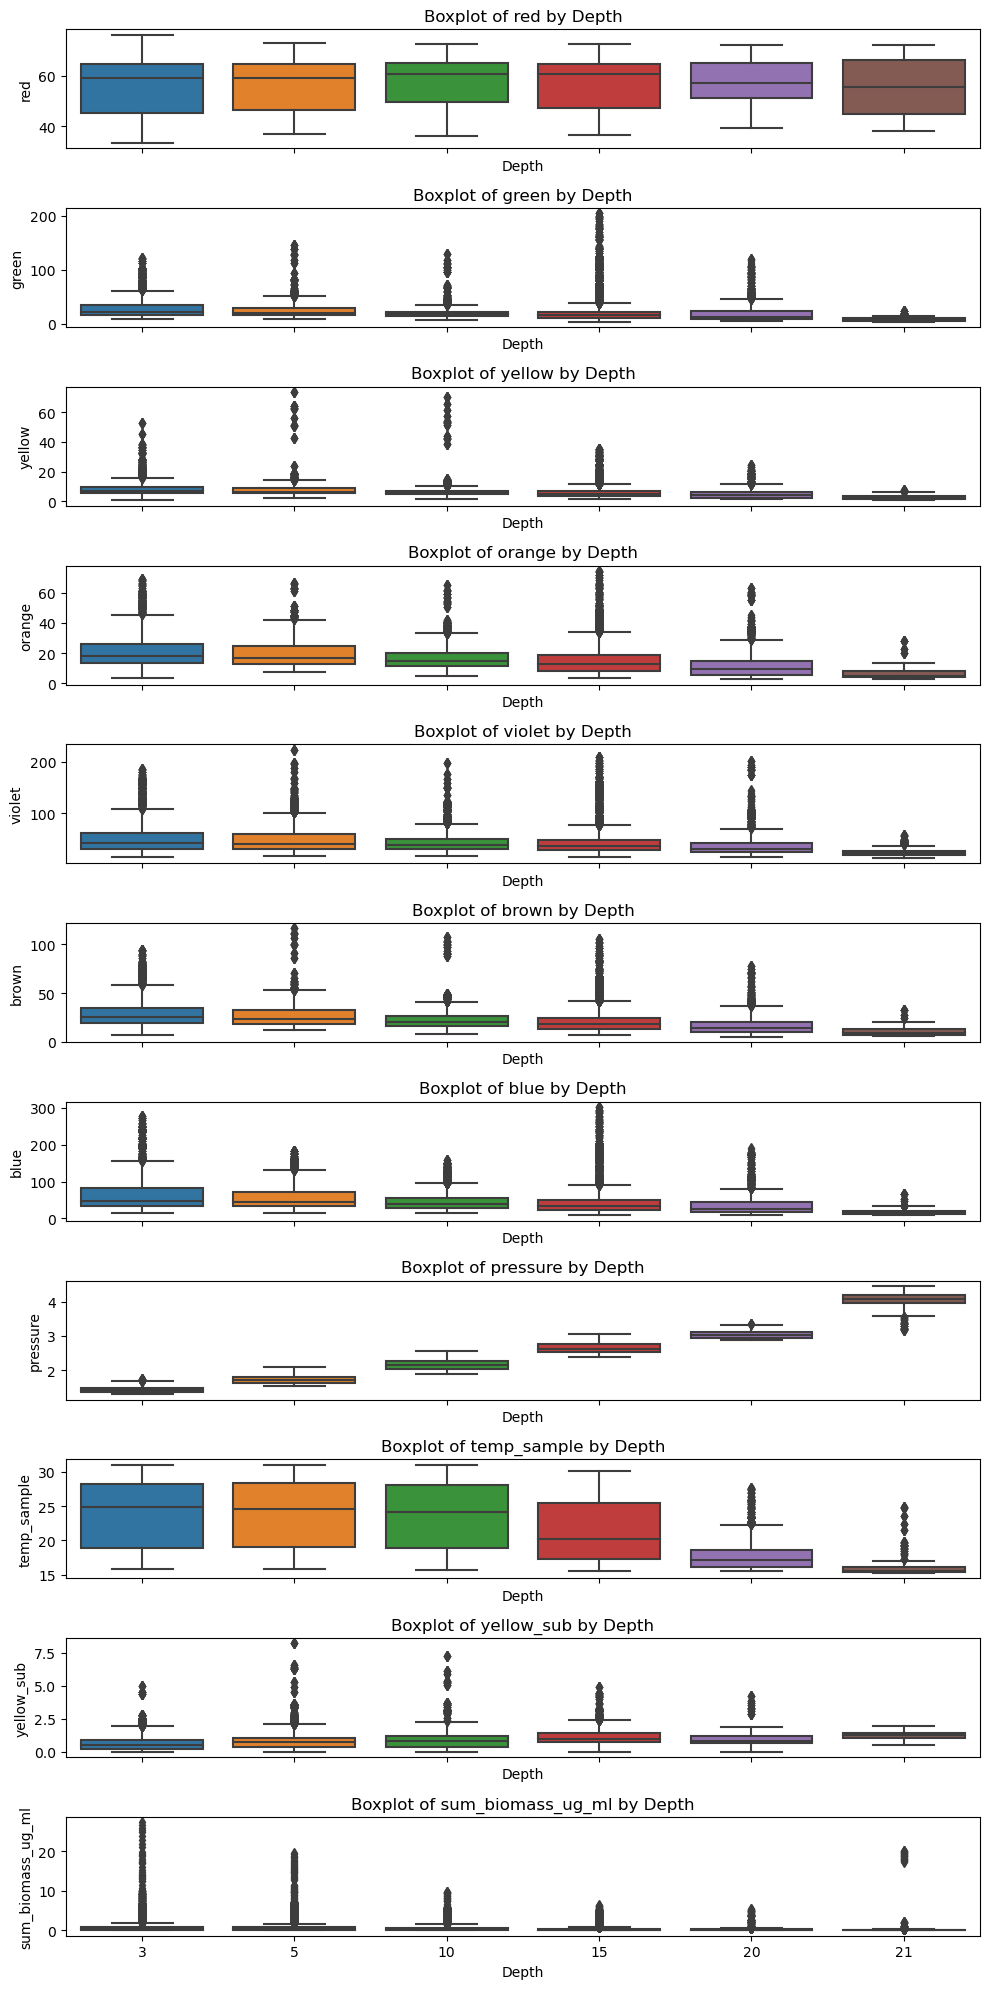

In [17]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [18]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [19]:
merged_train.shape

(52368, 18)

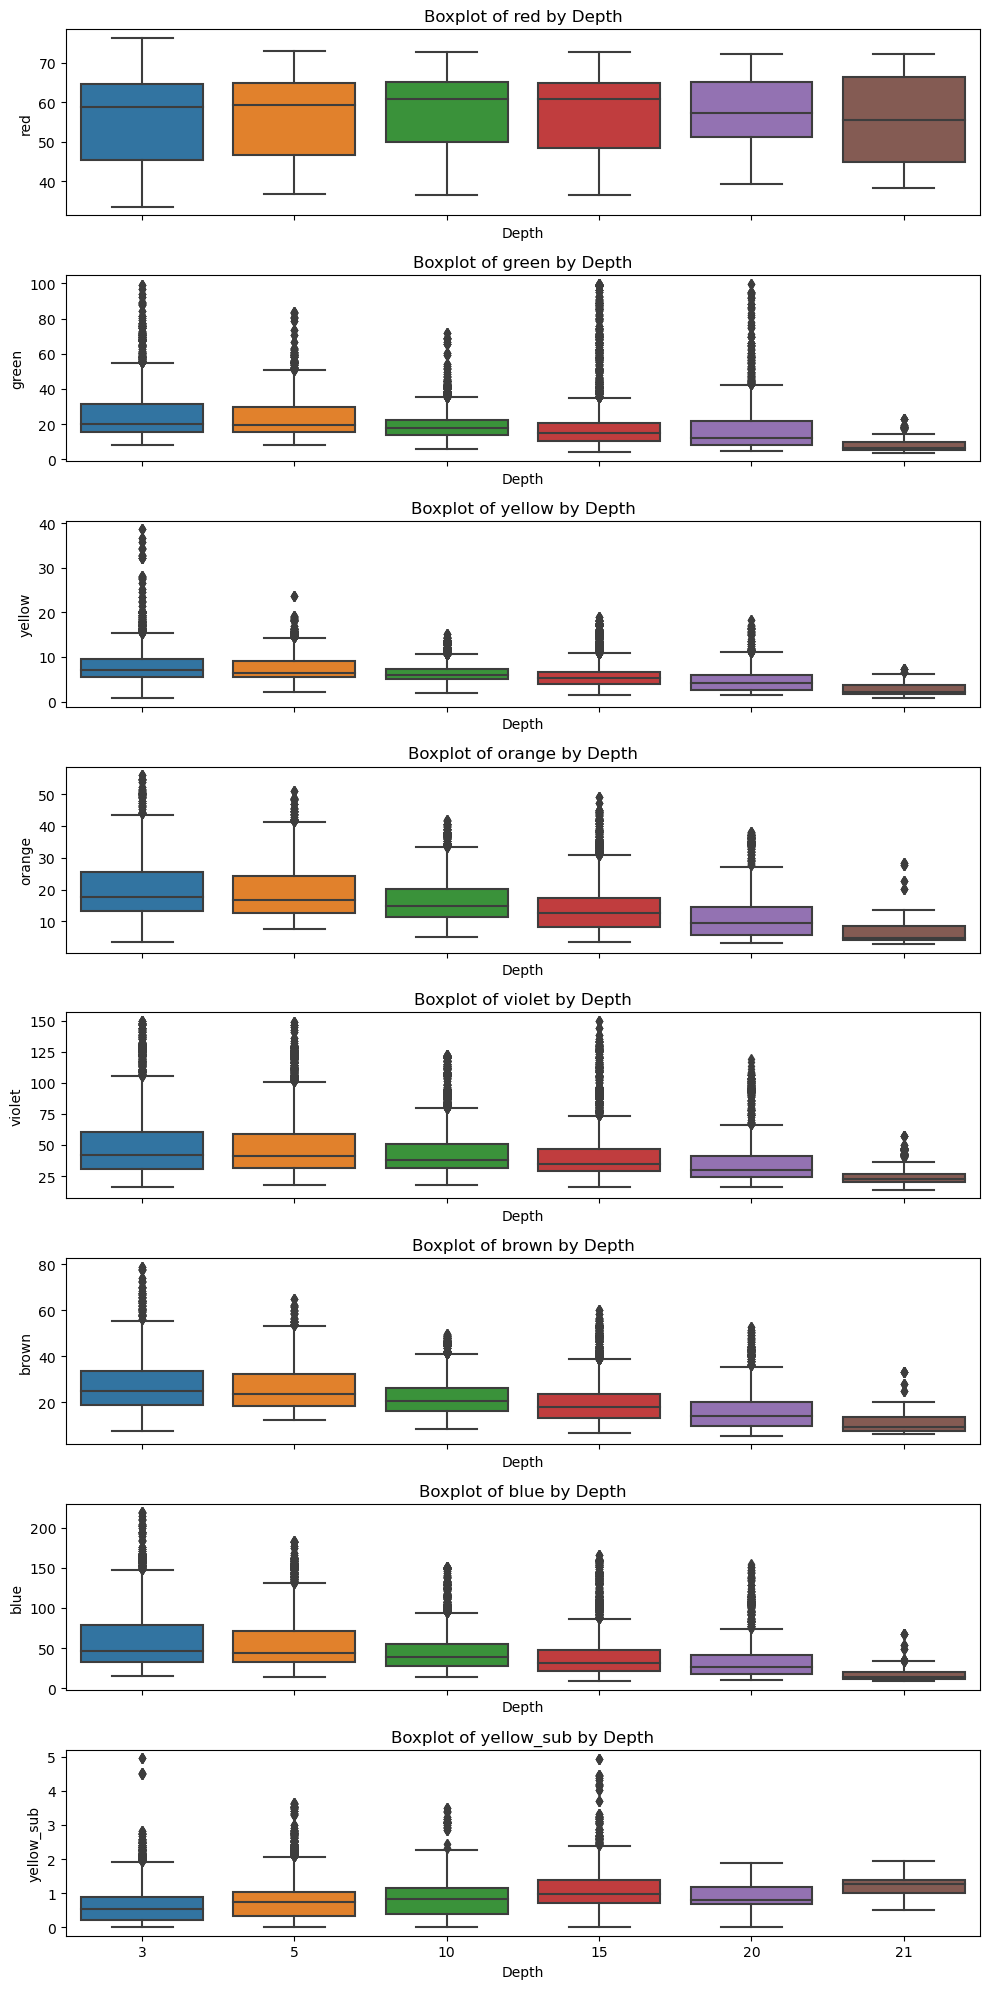

In [20]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

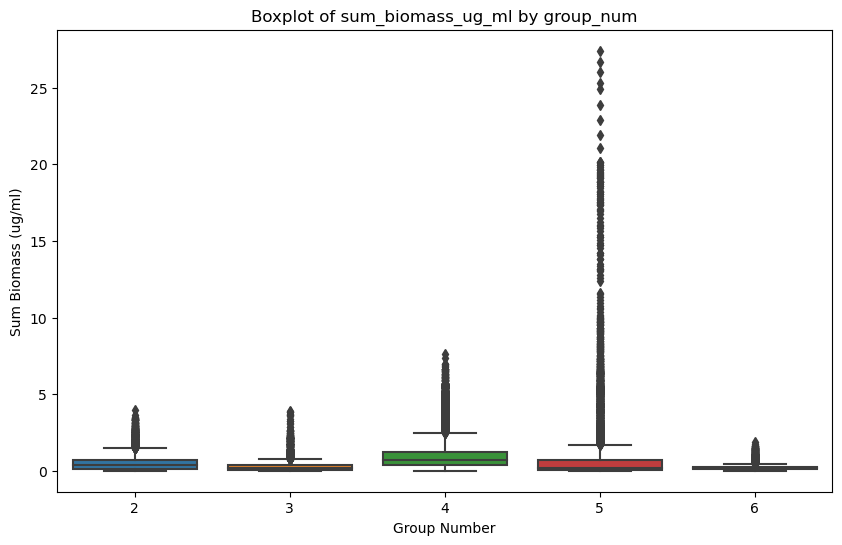

In [21]:
boxplot_biomass_by_group(merged_train)

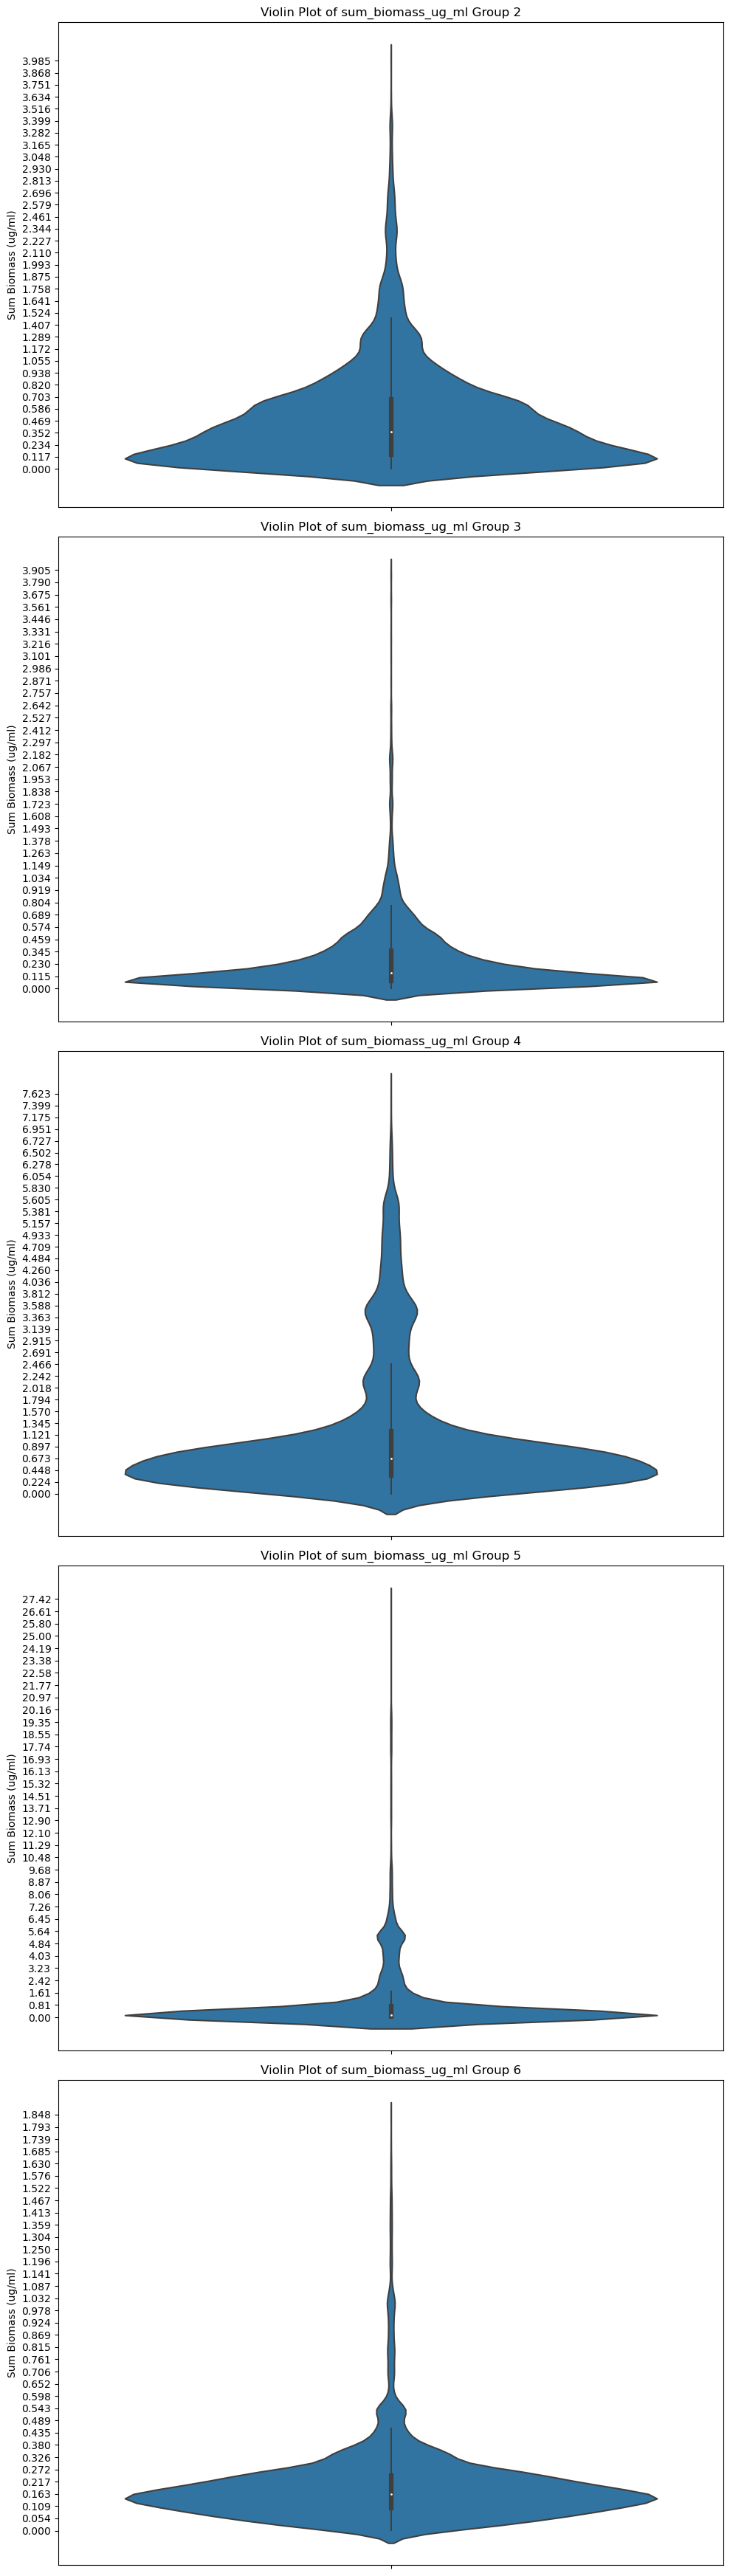

In [22]:
violin_biomass_by_group(merged_train)

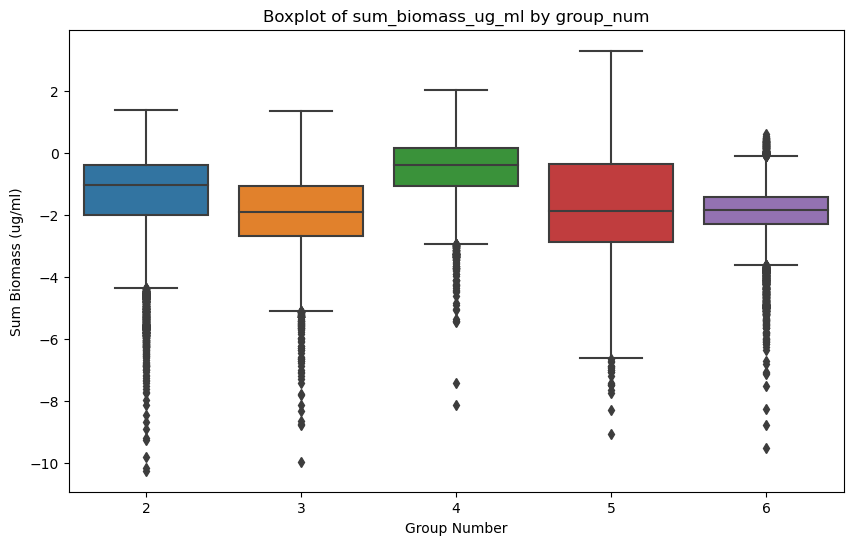

In [23]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

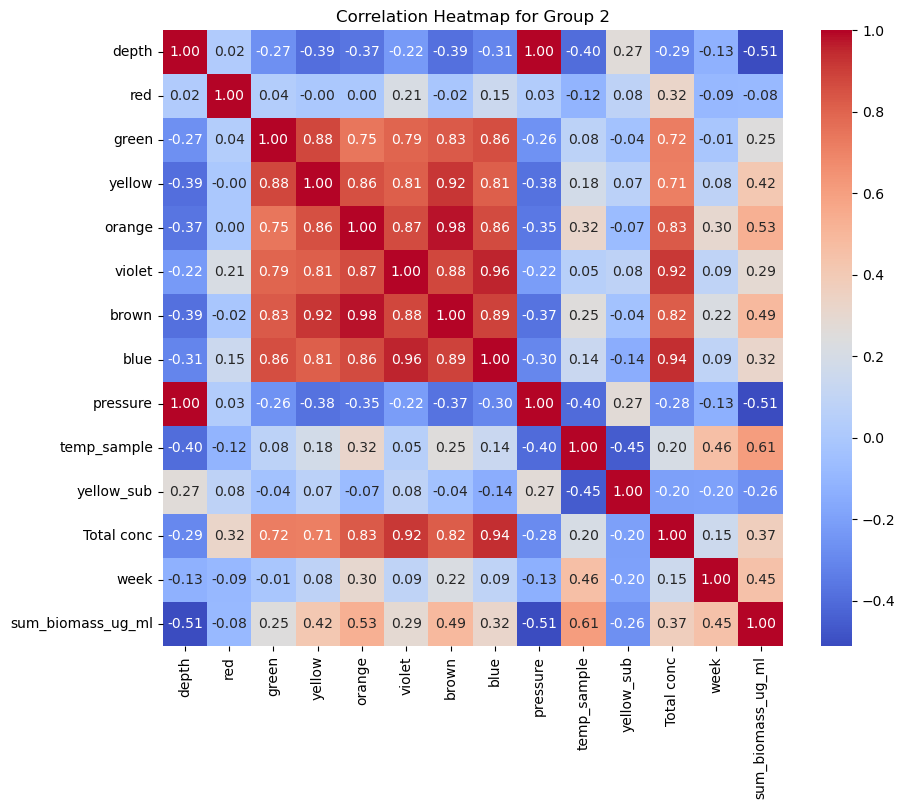

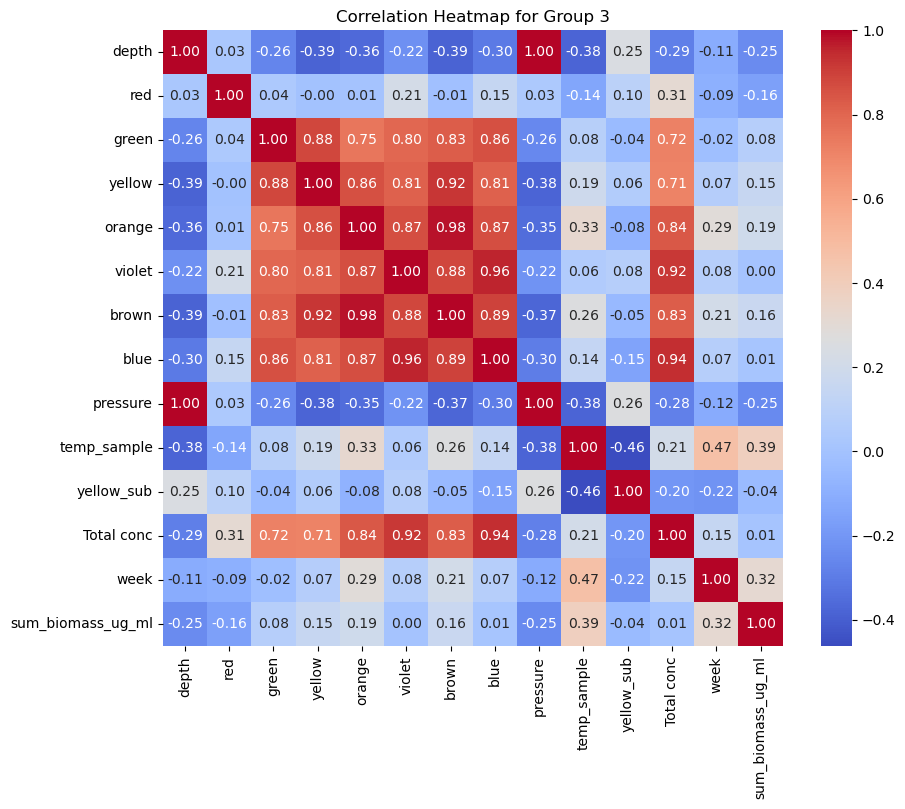

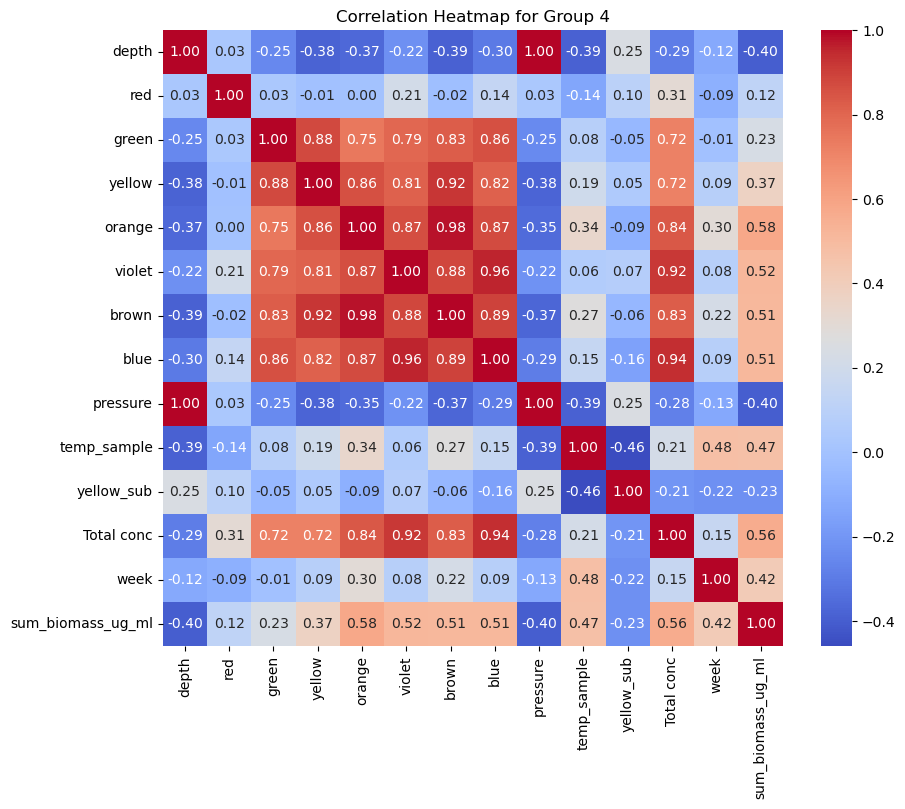

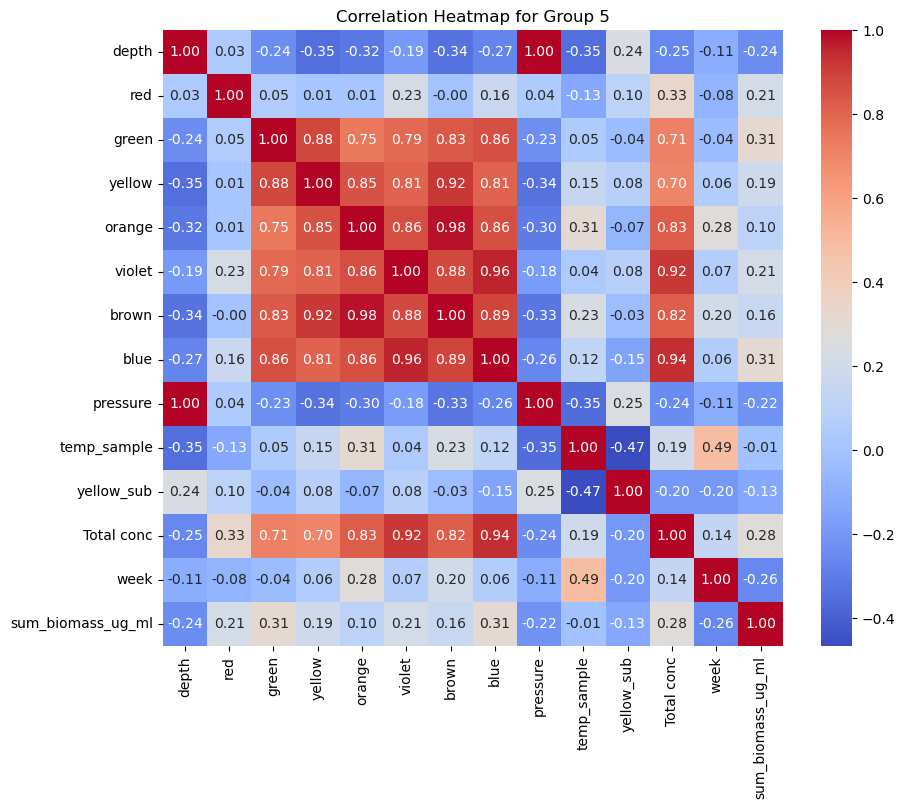

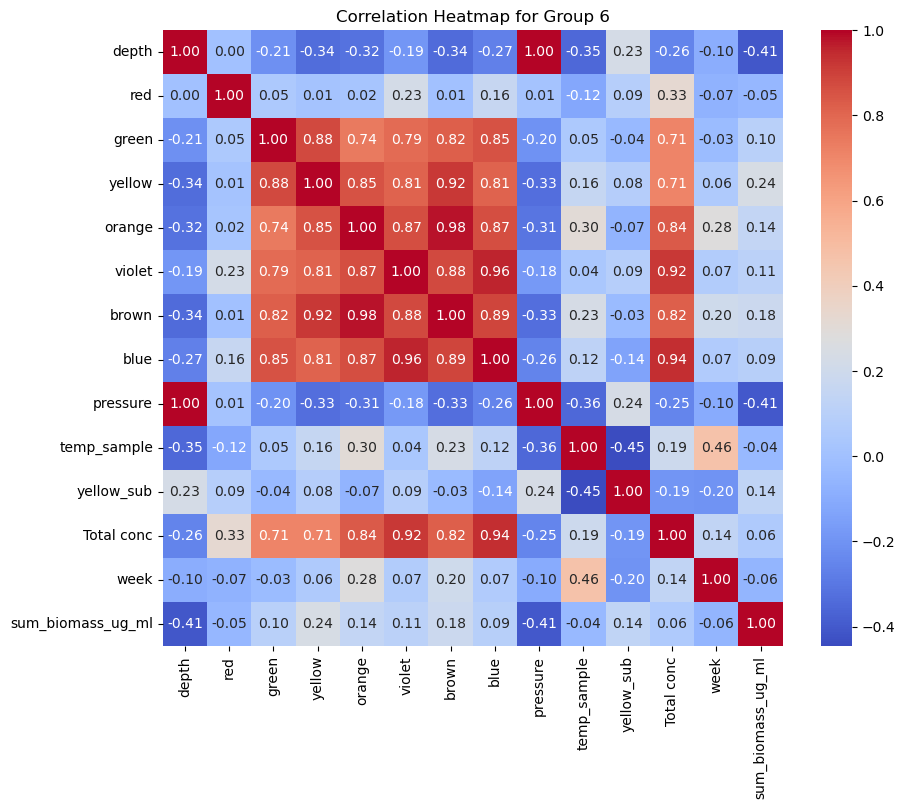

In [24]:
correlation_per_group(merged_train)

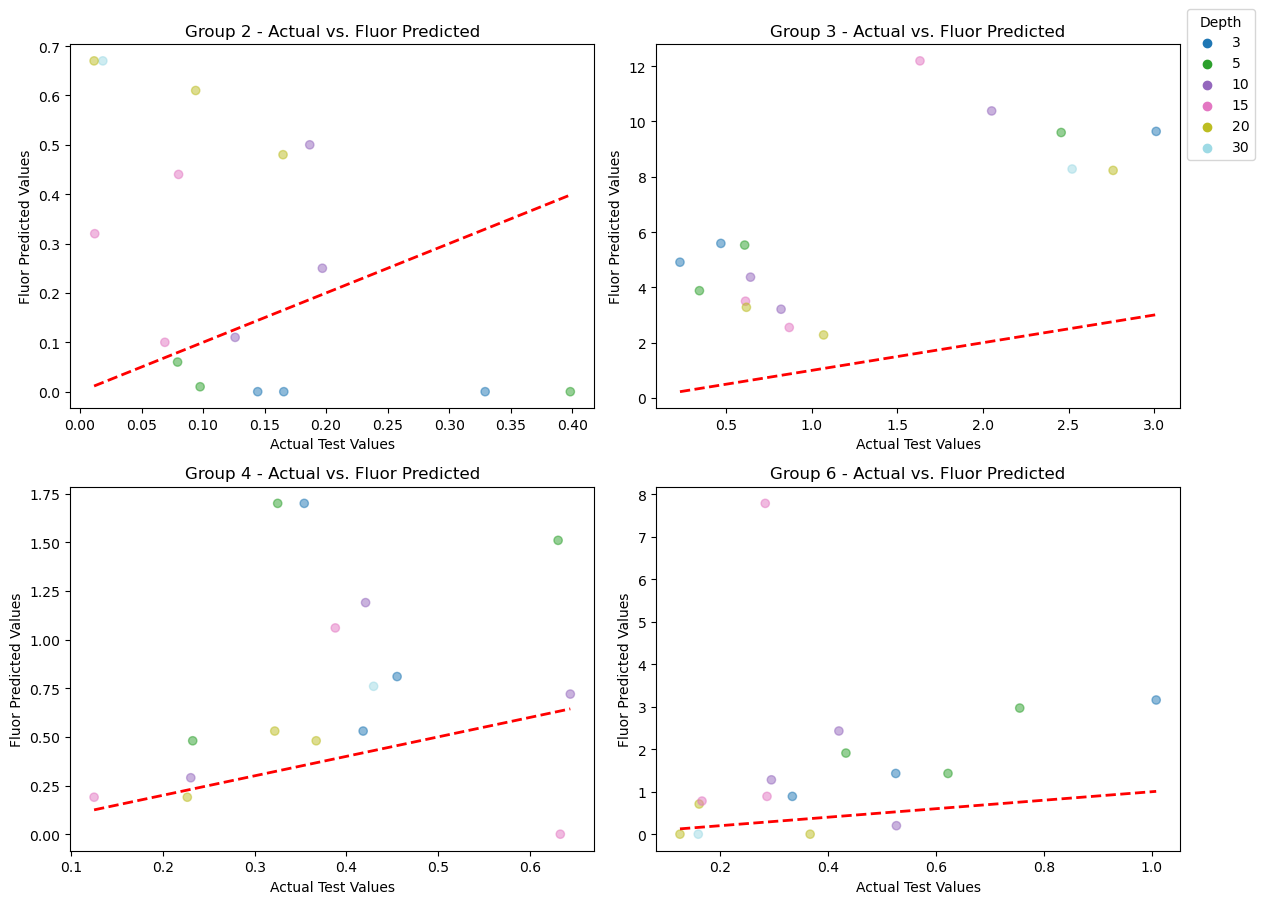

In [25]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

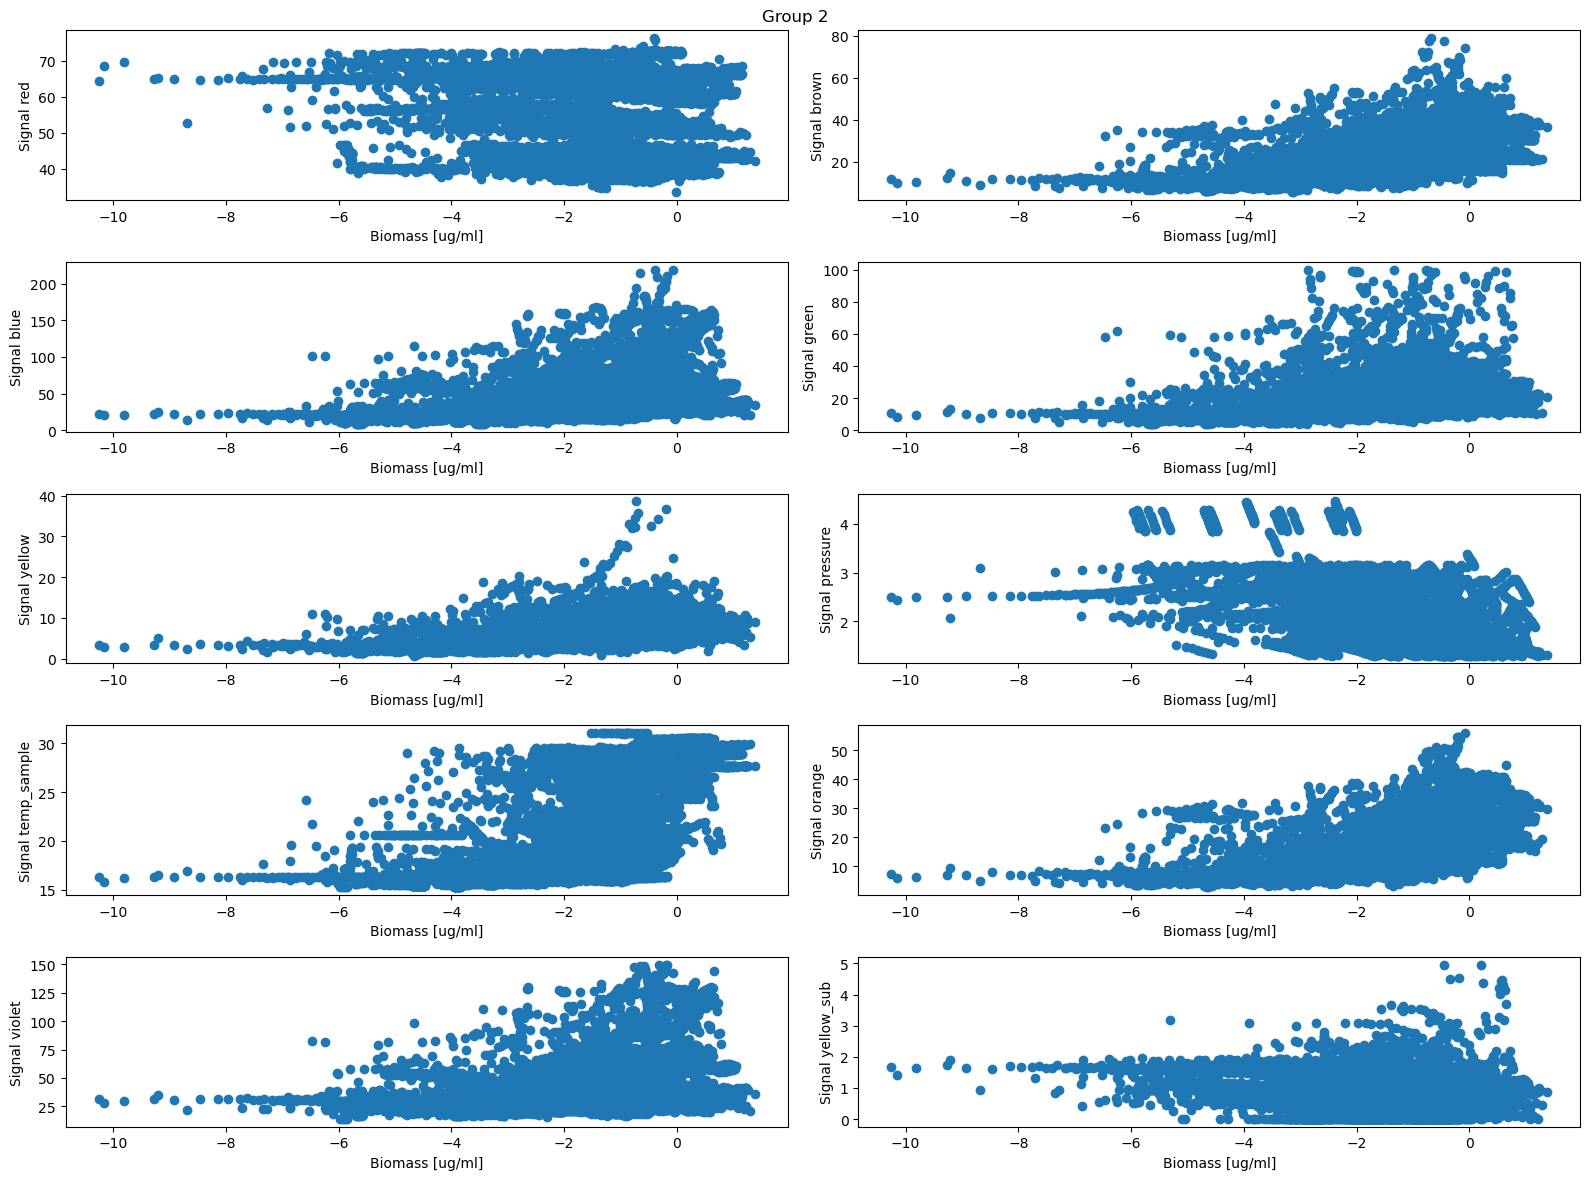

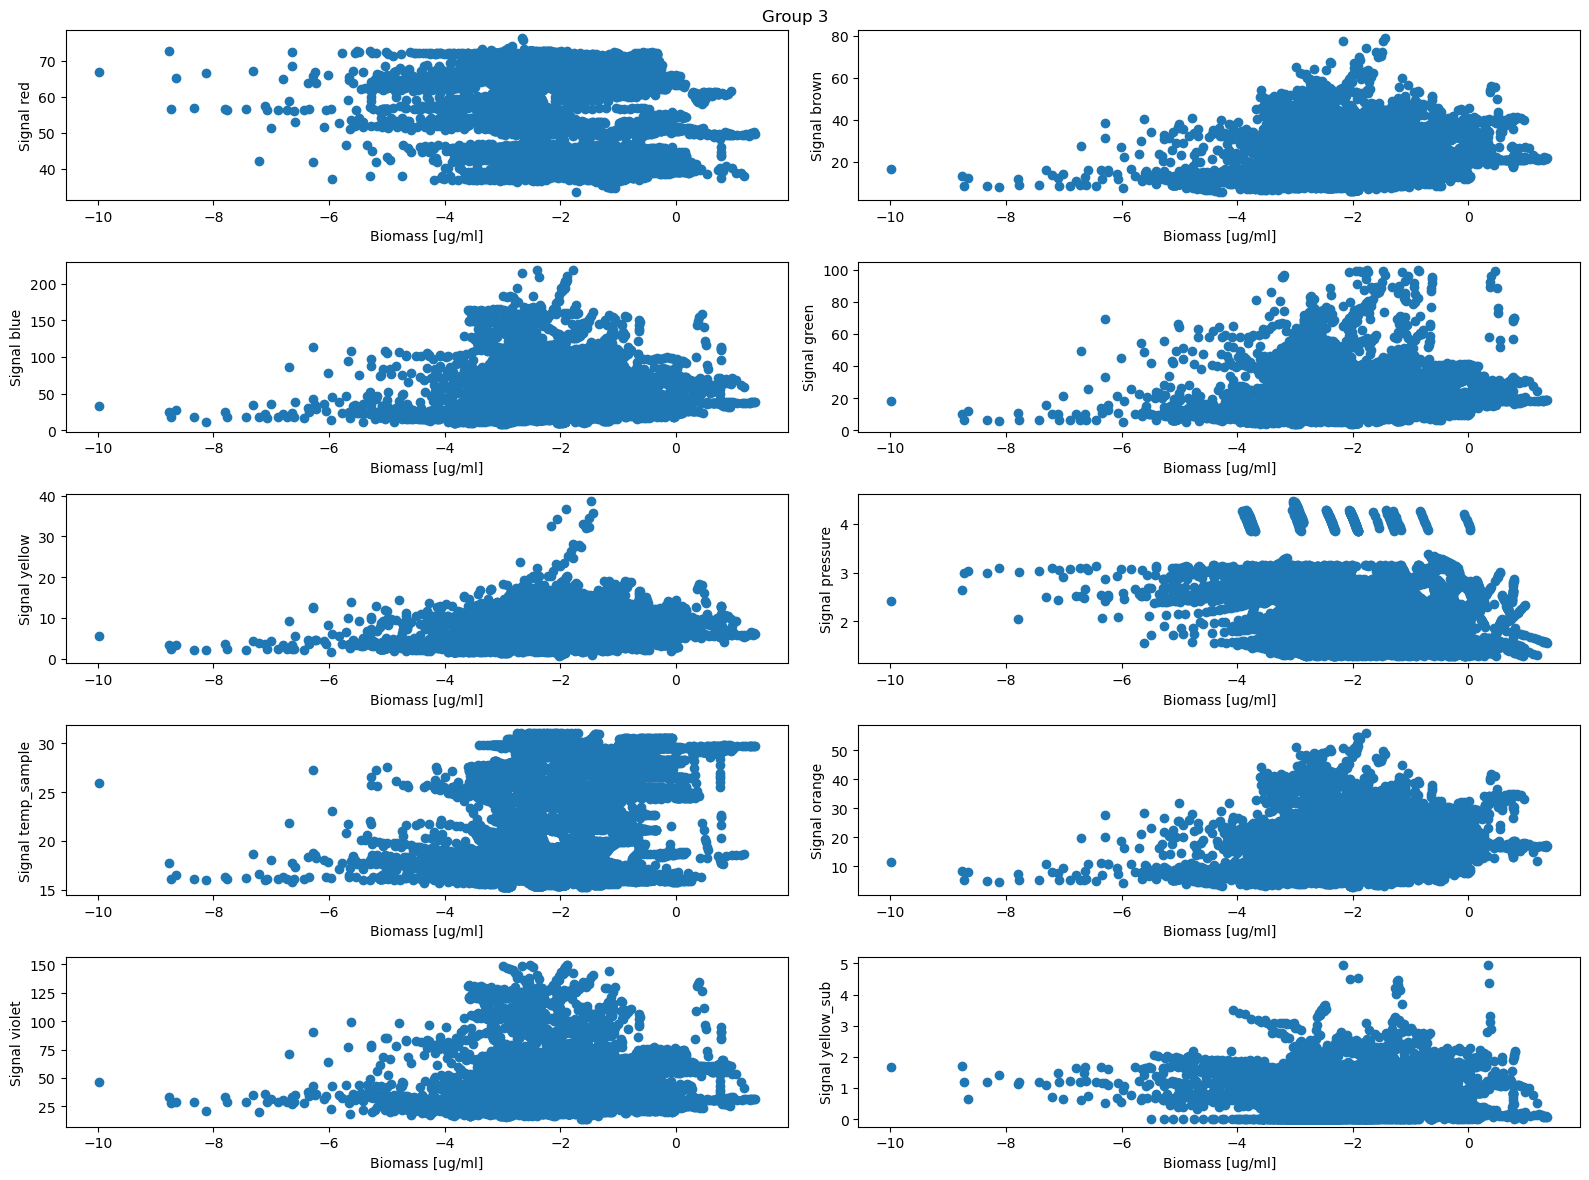

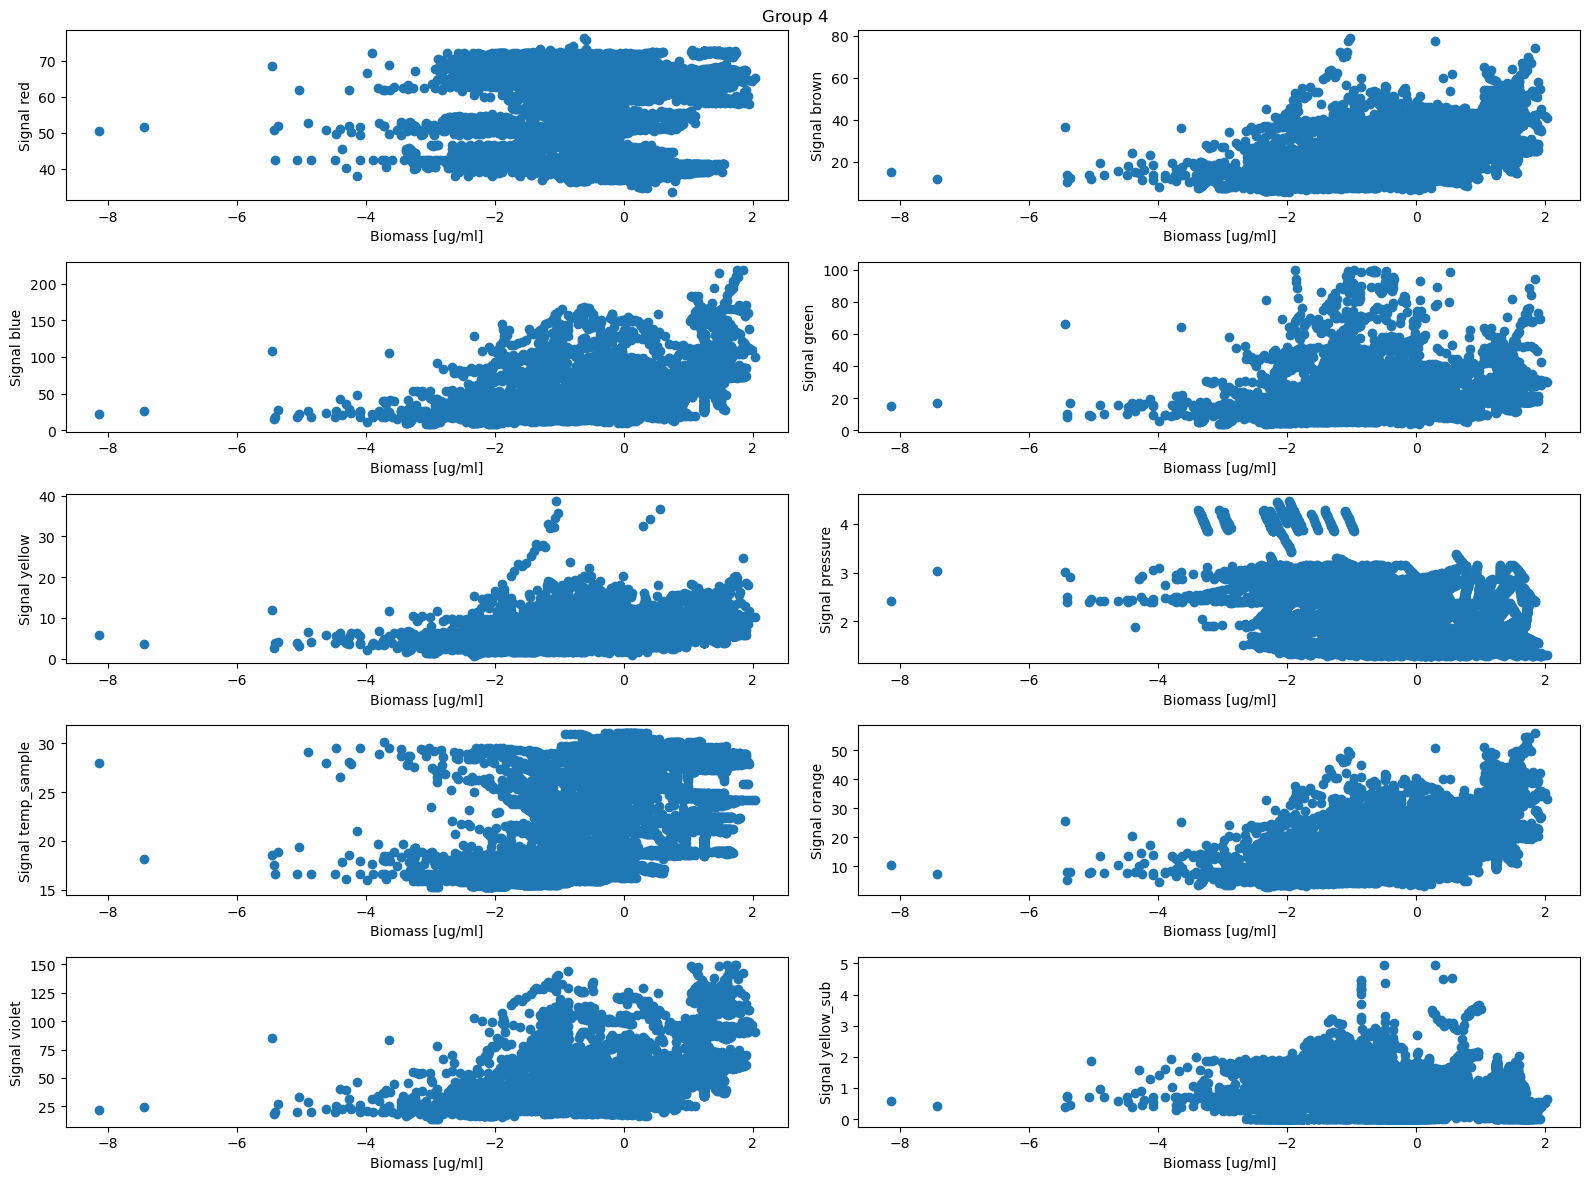

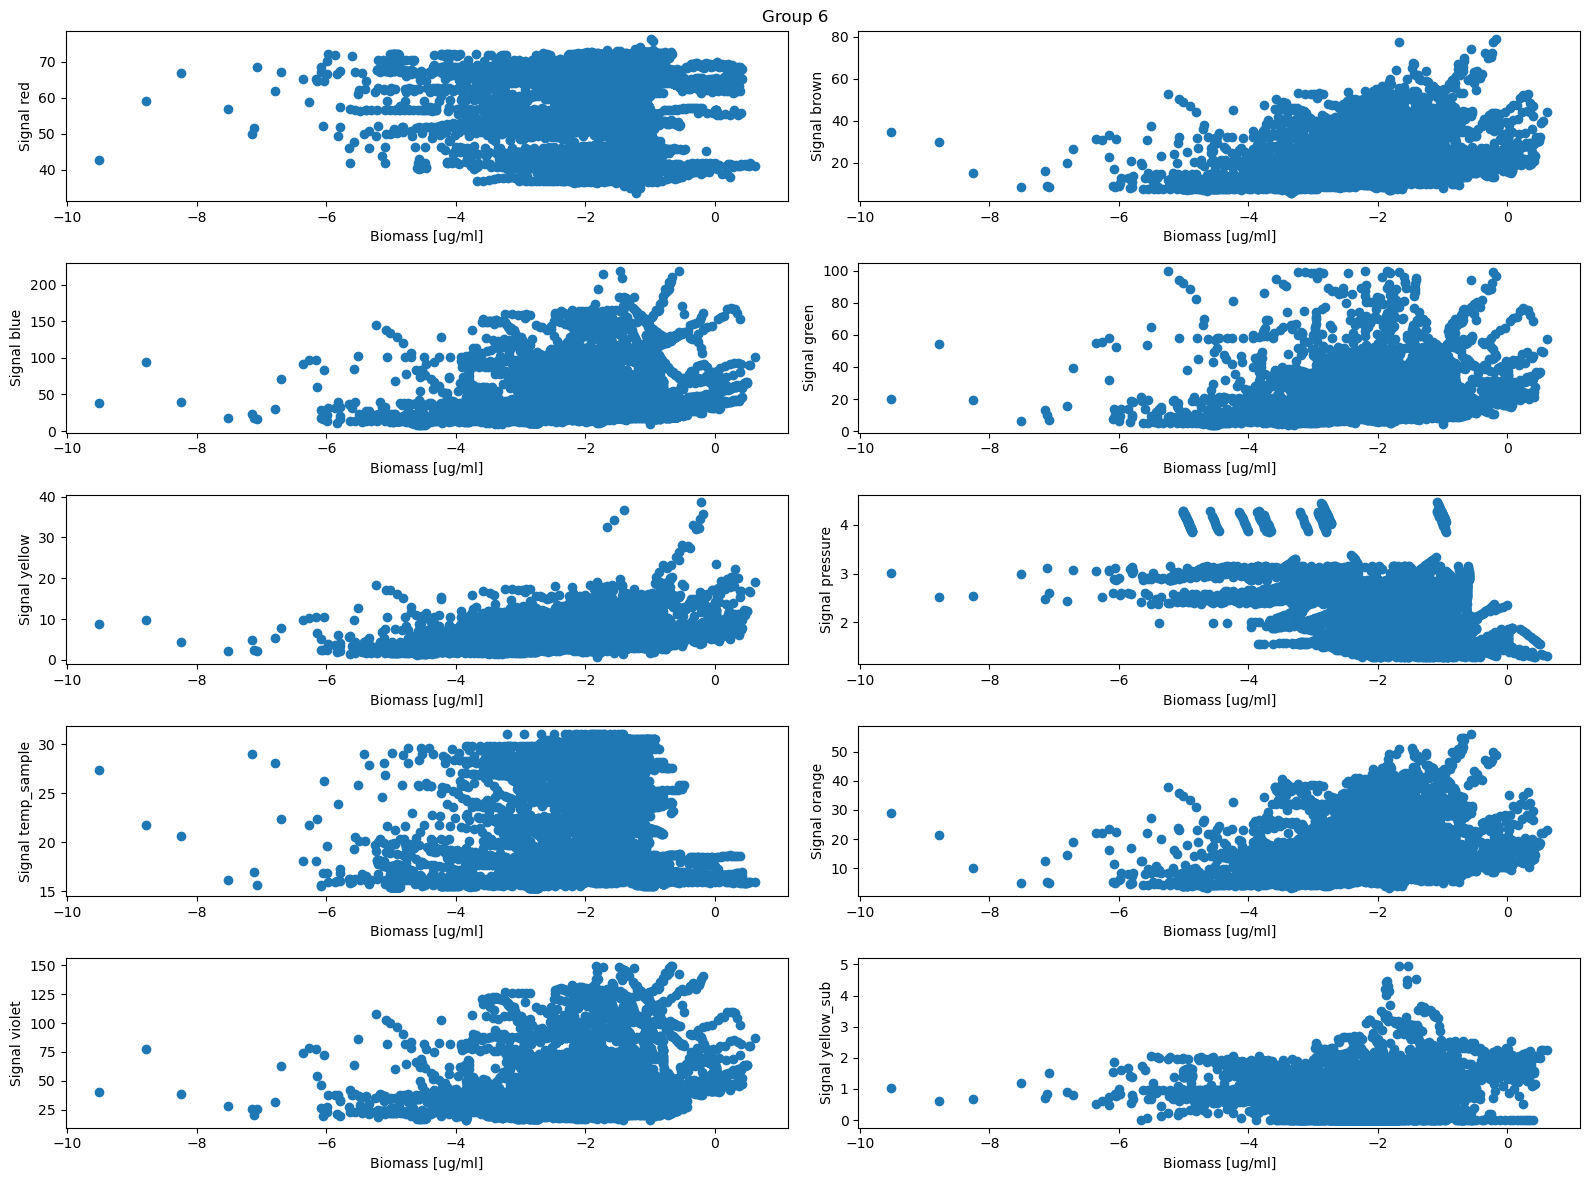

In [26]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

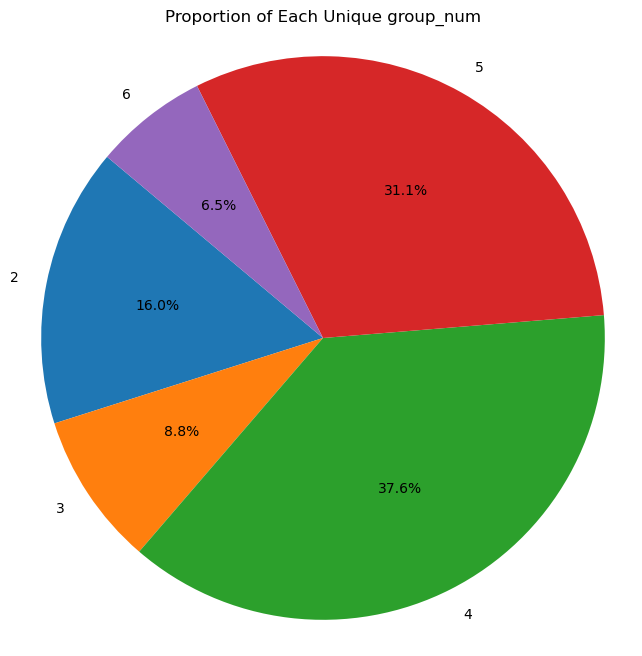

In [27]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [28]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)

# Training models and evaluating

In [29]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [30]:
if do_search:
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [31]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

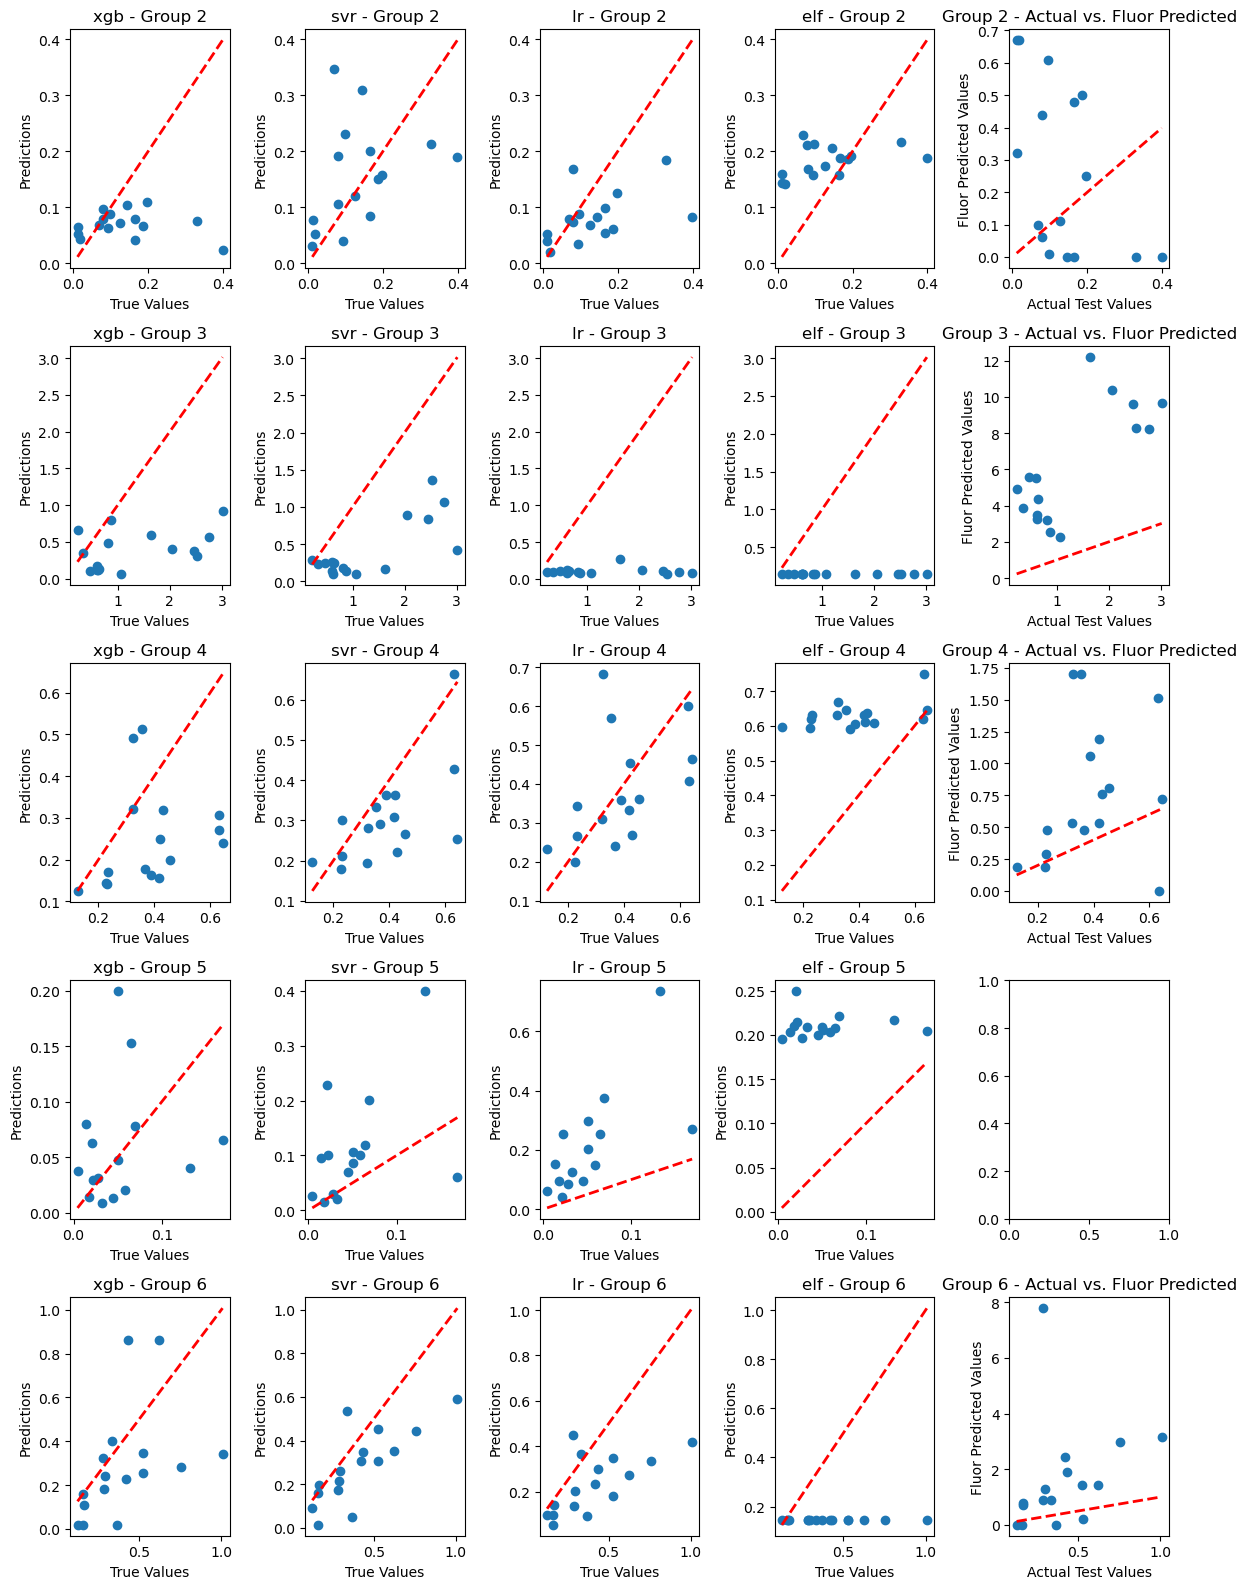

In [67]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [36]:
cleaned_res = compare_by_mpe(merged_val, regression_models, predict_fn=np.exp)

In [37]:
fp_res = calc_mpe_fp(fluor_val_df, with_group_5=False)

# With SMOGN

In [38]:
import smogn
import seaborn

In [39]:
smogn_file = './data/smogn_merged_train.pkl'
do_smogn = not os.path.exists(smogn_file)

In [40]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [41]:
regression_models_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

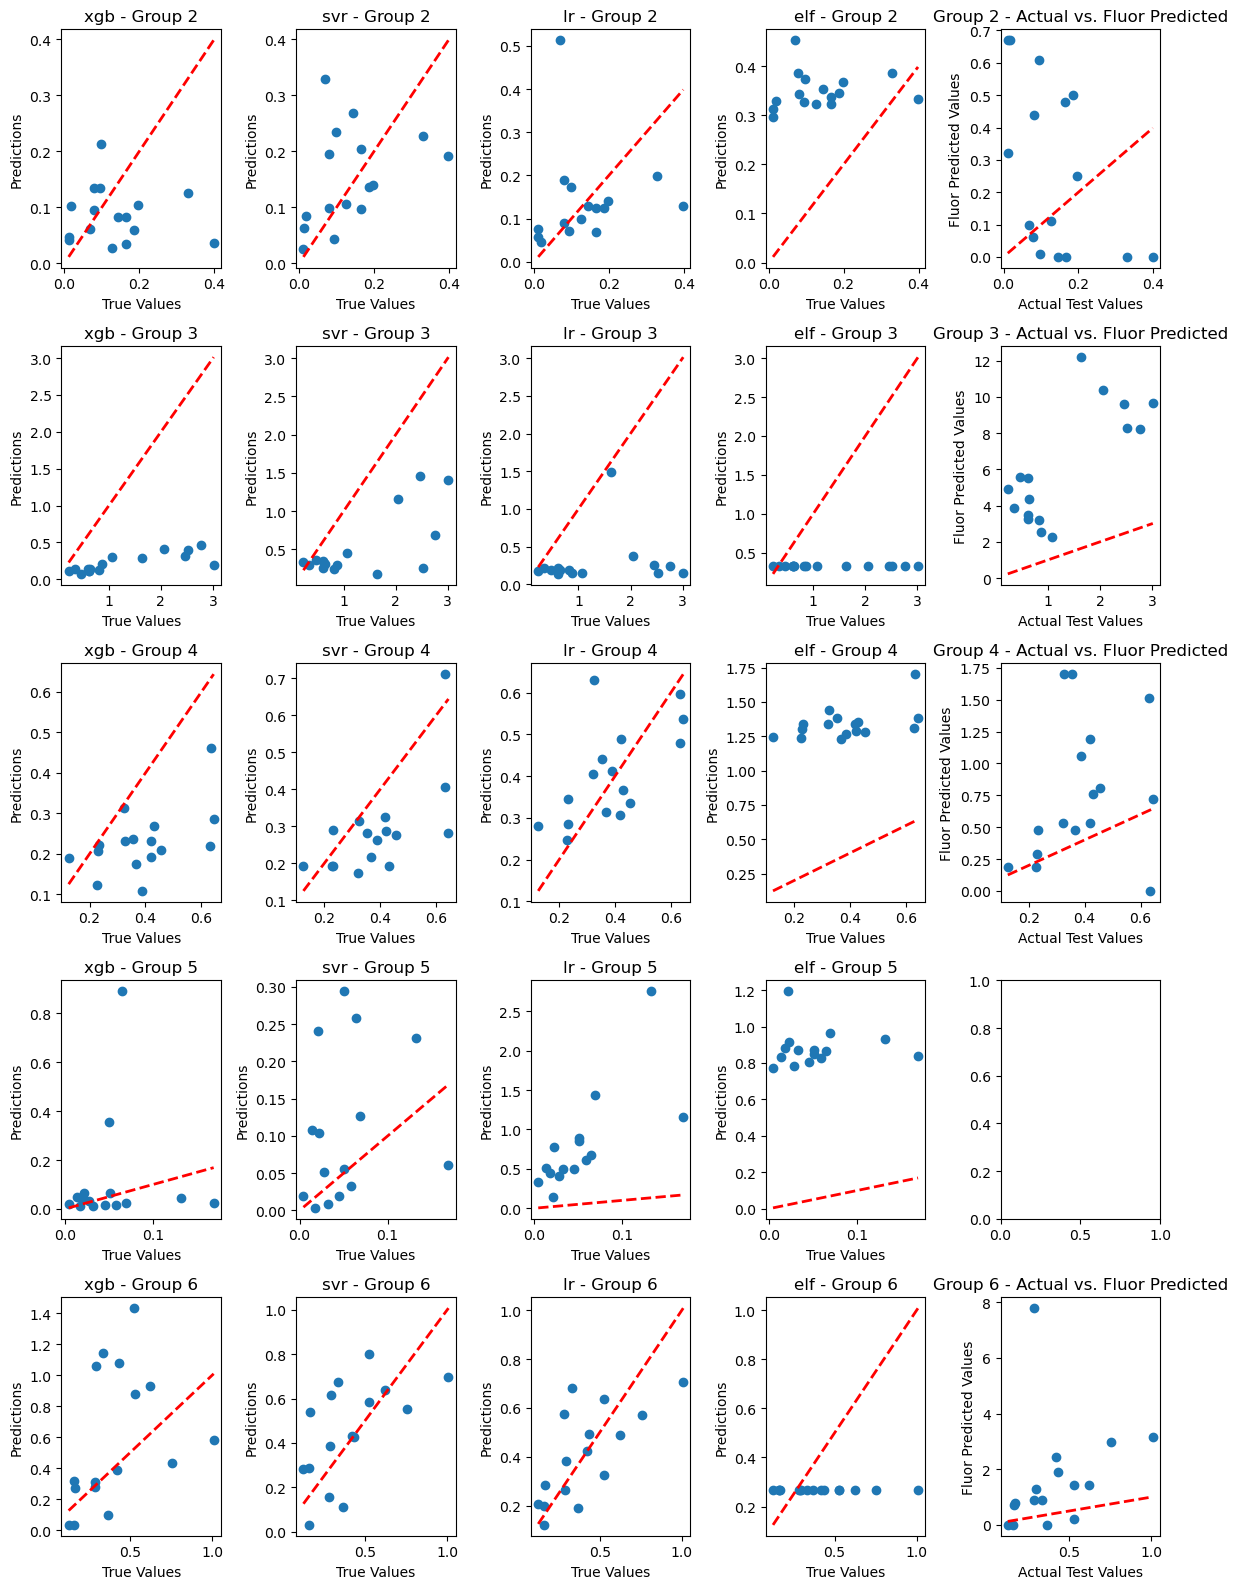

In [68]:
comparing_df_smogn = compare_all_models(regression_models_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [43]:
cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_smogn, predict_fn=np.exp)

# No Outliers Removal

In [44]:
regression_models_orig = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig[model_name], _ = train(model_name, orig_merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig['lr'], _ = train('lr', orig_merged_train, test_size=0.0, biomass_fn=np.log)

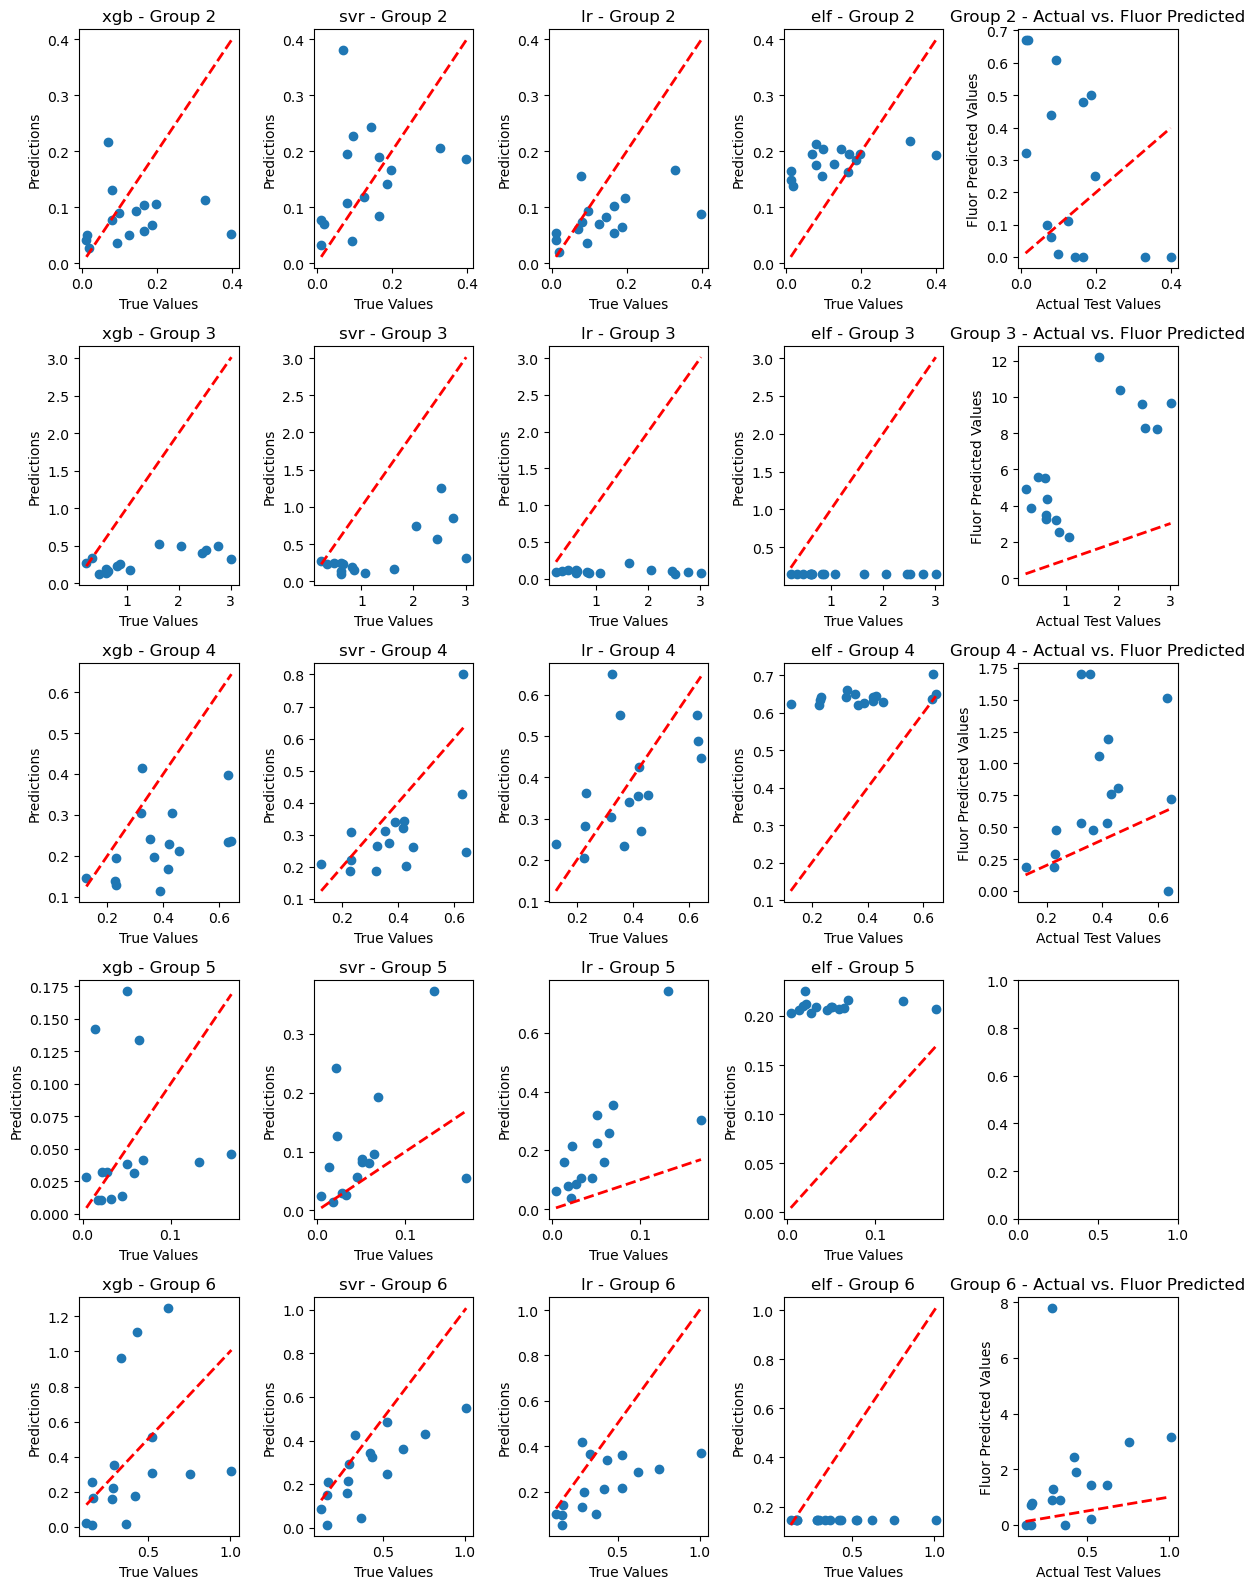

In [69]:
comparing_df_orig = compare_all_models(regression_models_orig, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [46]:
not_cleaned_res = compare_by_mpe(merged_val, regression_models_orig, predict_fn=np.exp)

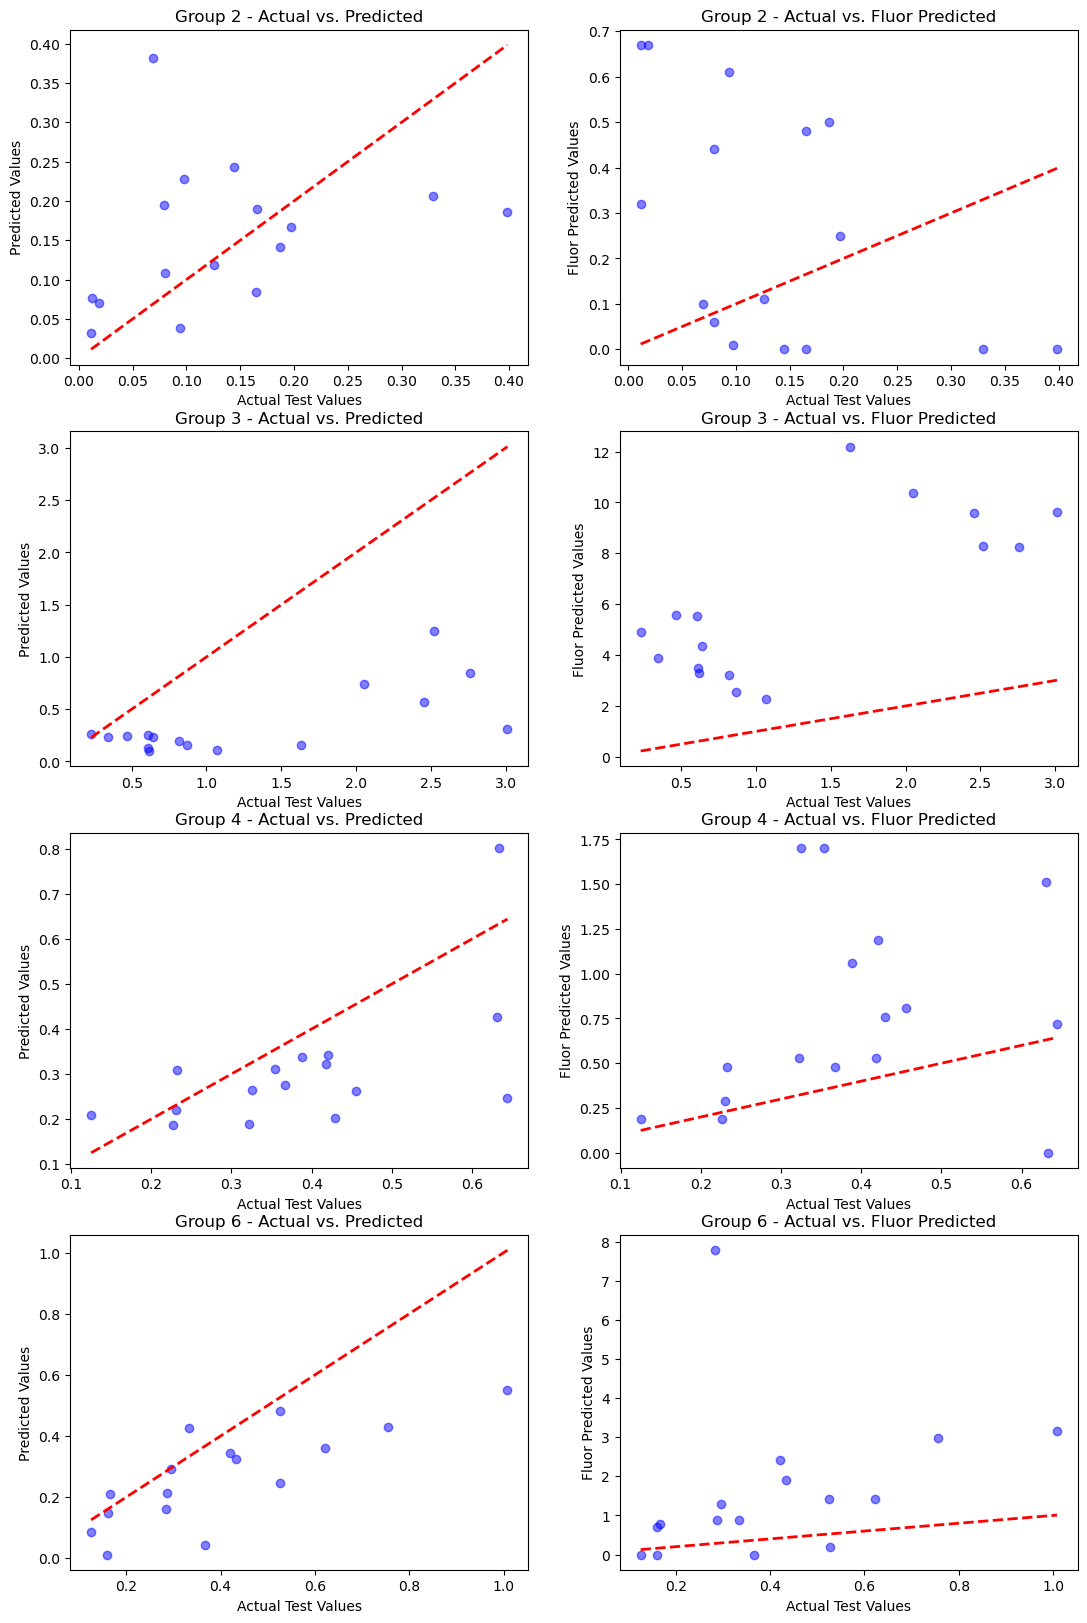

In [47]:
compare_to_fluor(regression_models_orig['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)

# With Outliers With Smogn

In [48]:
smogn_file = './data/with_outliers_smogn_merged_train.pkl'
do_smogn = not os.path.exists(smogn_file)

In [49]:
if do_smogn:
    orig_merged_train_smogn = []
    for group_num in orig_merged_train['group_num'].unique():
        group_df = orig_merged_train[orig_merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        orig_merged_train_smogn.append(group_df_smogn)


    orig_merged_train_smogn_concat = pd.concat(orig_merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(orig_merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        orig_merged_train_smogn_concat = pickle.load(f)

In [50]:
regression_models_orig_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig_smogn[model_name], _ = train(model_name, orig_merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig_smogn['lr'], _ = train('lr', orig_merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

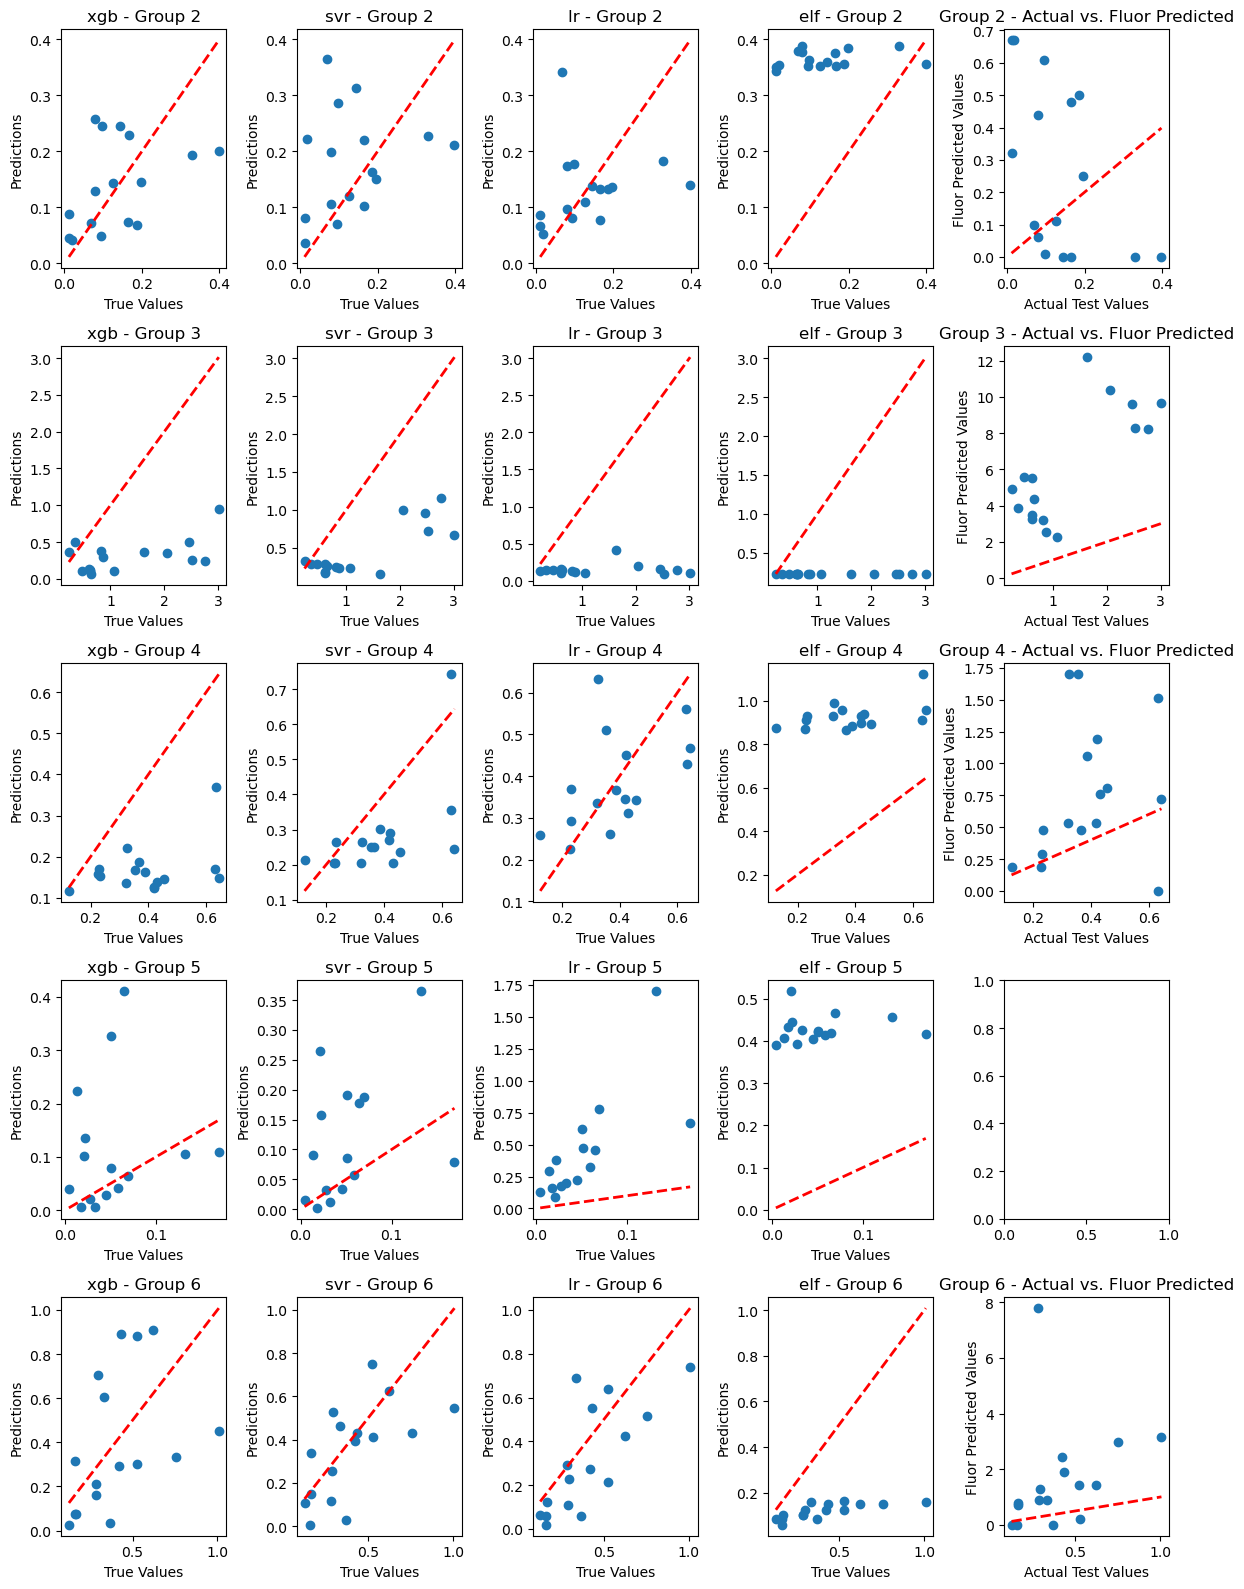

In [70]:
comparing_df_orig_smogn = compare_all_models(regression_models_orig_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [52]:
not_cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_orig_smogn, predict_fn=np.exp)

# Compare All Methods

In [53]:
fp_res['Source'] = 'FP'
cleaned_res['Source'] = 'Cleaned'
cleaned_smogn_res['Source'] = 'Cleaned SMOGN'
not_cleaned_res['Source'] = 'Not Cleaned'
not_cleaned_smogn_res['Source'] = 'Not Cleaned SMOGN'

all_results = pd.concat([fp_res, cleaned_res, cleaned_smogn_res, not_cleaned_res, not_cleaned_smogn_res])
all_results

Model          2          3          4          6             Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                 FP   
0   xgb   5.345828  24.649874  12.069362  10.882341            Cleaned   
1   svr   6.109543  23.714703   9.992070   6.829568            Cleaned   
2   elf   7.916731  40.980278  29.984425  10.426962            Cleaned   
3    lr   3.945039  40.915492  21.441185   7.976251            Cleaned   
0   xgb   6.176530  30.868779   9.617567  25.762598      Cleaned SMOGN   
1   svr   5.009404  19.646417   6.289790  12.420756      Cleaned SMOGN   
2   elf   6.265390  41.487583  24.781807  11.840332      Cleaned SMOGN   
3    lr   4.948935  38.241393   8.675365   6.890694      Cleaned SMOGN   
0   xgb   5.087548  23.057366   9.919594  16.249841        Not Cleaned   
1   svr   6.386435  24.467297  10.518729   7.427699        Not Cleaned   
2   elf   7.793360  41.087621  30.406158  10.443082        Not Cleaned   
3    lr   3.925578  41.062796  21.625474   8.871652        Not Cleaned   
0   xgb   7.308988  26.258792  10.022393  14.231214  Not Cleaned SMOGN   
1   svr   6.768006  21.415471   7.831283  10.407384  Not Cleaned SMOGN   
2   elf  11.334976  41.056854  27.046373  14.017906  Not Cleaned SMOGN   
3    lr   6.387670  39.334886  14.676578   5.406184  Not Cleaned SMOGN   

           5  
0        NaN  
0   5.061026  
1   5.835080  
2  12.539294  
3  15.517819  
0   6.452296  
1   4.657610  
2  23.575957  
3  32.601213  
0   4.262437  
1   5.730173  
2  12.462001  
3  15.593274  
0   7.575693  
1   5.387851  
2  16.983057  
3  23.531879

# Custom SMOGN

In [56]:
k = 15
samp_method = 'extreme'
rel_thres = 0.9
rel_method = 'auto'
rel_xtrm_type = 'high'
rel_coef = 1.9

arg_name = f"k_{k}_samp_meth_{samp_method}_rel_thres_{''.join(str(rel_thres).split('.'))}_rel_meth_{rel_method}_rel_x_t_{rel_xtrm_type}_rel_coef_{''.join(str(rel_coef).split('.'))}"
smogn_file = f'./data/smogn_{arg_name}.pkl'
do_smogn = not os.path.exists(smogn_file)

In [57]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml',  ## string ('header name')
            k=k,
            samp_method=samp_method,
            rel_thres=rel_thres,
            rel_method=rel_method,
            rel_xtrm_type=rel_xtrm_type,
            rel_coef=rel_coef
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [58]:
regression_models_custom_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_custom_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_custom_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

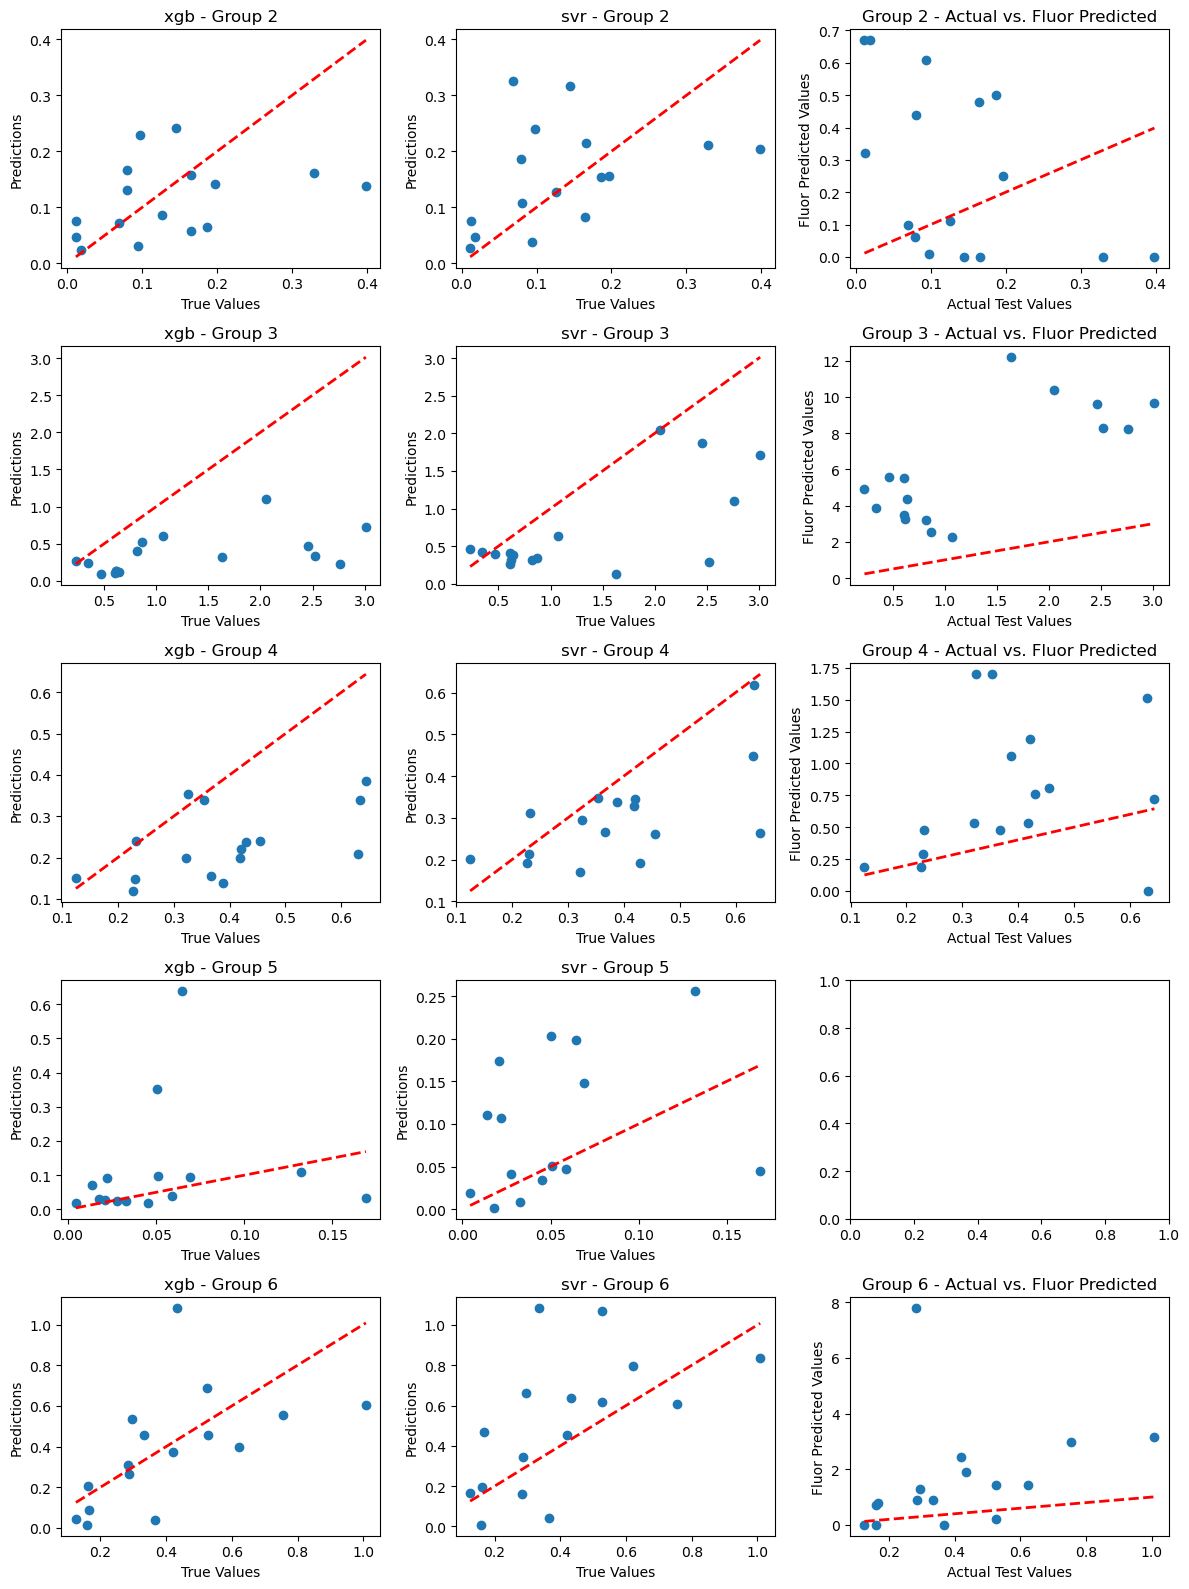

In [83]:
comparing_df_custom_smogn = compare_all_models(regression_models_custom_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [60]:
cleaned_custom_smogn_res = compare_by_mpe(merged_val, regression_models_custom_smogn, predict_fn=np.exp)

In [64]:
cleaned_custom_smogn_res['Source'] = 'Cleaned Custom SMOGN'

all_results = pd.concat([all_results, cleaned_custom_smogn_res])
all_results

Model          2          3          4          6                Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                    FP   
0   xgb   5.345828  24.649874  12.069362  10.882341               Cleaned   
1   svr   6.109543  23.714703   9.992070   6.829568               Cleaned   
2   elf   7.916731  40.980278  29.984425  10.426962               Cleaned   
3    lr   3.945039  40.915492  21.441185   7.976251               Cleaned   
0   xgb   6.176530  30.868779   9.617567  25.762598         Cleaned SMOGN   
1   svr   5.009404  19.646417   6.289790  12.420756         Cleaned SMOGN   
2   elf   6.265390  41.487583  24.781807  11.840332         Cleaned SMOGN   
3    lr   4.948935  38.241393   8.675365   6.890694         Cleaned SMOGN   
0   xgb   5.087548  23.057366   9.919594  16.249841           Not Cleaned   
1   svr   6.386435  24.467297  10.518729   7.427699           Not Cleaned   
2   elf   7.793360  41.087621  30.406158  10.443082           Not Cleaned   
3    lr   3.925578  41.062796  21.625474   8.871652           Not Cleaned   
0   xgb   7.308988  26.258792  10.022393  14.231214     Not Cleaned SMOGN   
1   svr   6.768006  21.415471   7.831283  10.407384     Not Cleaned SMOGN   
2   elf  11.334976  41.056854  27.046373  14.017906     Not Cleaned SMOGN   
3    lr   6.387670  39.334886  14.676578   5.406184     Not Cleaned SMOGN   
0   xgb   4.846586  22.322134   9.025584  12.428564  Cleaned Custom SMOGN   
1   svr   4.733655  17.407405   6.645951  10.636181  Cleaned Custom SMOGN   
2   elf   5.616842  39.529975  23.659239  10.714374  Cleaned Custom SMOGN   
3    lr   4.778887  35.560771   7.840352   5.591564  Cleaned Custom SMOGN   

           5  
0        NaN  
0   5.061026  
1   5.835080  
2  12.539294  
3  15.517819  
0   6.452296  
1   4.657610  
2  23.575957  
3  32.601213  
0   4.262437  
1   5.730173  
2  12.462001  
3  15.593274  
0   7.575693  
1   5.387851  
2  16.983057  
3  23.531879  
0   6.395571  
1   3.633513  
2  22.433836  
3  31.121577

In [105]:
def bar_plot_per_model_by_sources(df, model_name):
    # Filter the DataFrame for the selected 'Model'
    model_data = pd.concat([df[df['Model'] == model_name], df[df['Model'] == 'FP']])

    # Columns to be plotted
    columns_to_plot = [2, 3, 4, 5, 6]

    # Group the data by the 'Source' column and calculate the mean for each column
    grouped_data = model_data.groupby('Source')[columns_to_plot].mean()

    # Transpose the grouped data for easier plotting
    grouped_data = grouped_data.transpose()

    # Plot the multi-group bar chart
    ax = grouped_data.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Groups')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title(f'Multi-Group Bar Plot for Model: {selected_model}')
    plt.legend(title='Source', loc='upper right')
    plt.xticks(range(len(columns_to_plot)), columns_to_plot)
    plt.show()

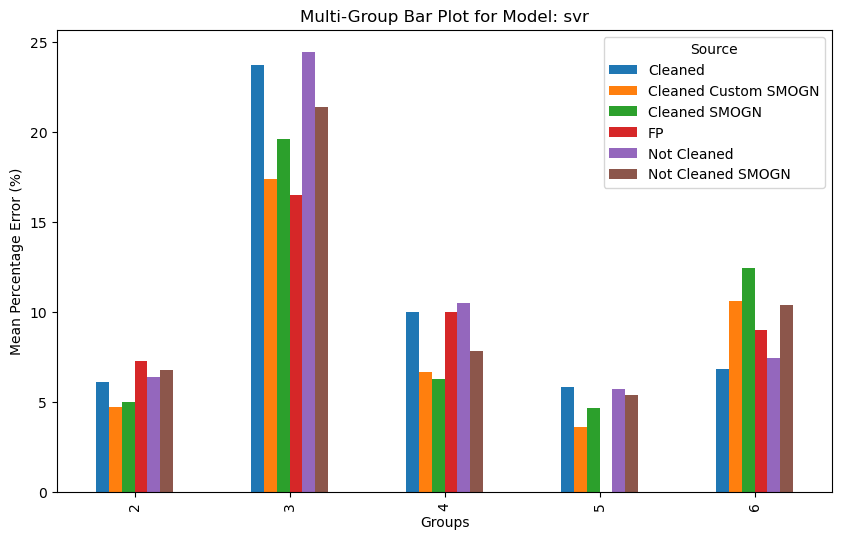

In [106]:
bar_plot_per_model_by_sources(all_results, 'svr')

In [81]:
comparing_df['Source'] = 'Cleaned'
comparing_df_smogn['Source'] = 'Cleaned SMOGN'
comparing_df_orig['Source'] = 'Not Cleaned'
comparing_df_orig_smogn['Source'] = 'Not Cleaned SMOGN'
comparing_df_custom_smogn['Source'] = 'Cleaned Custom SMOGN'
mse_all_results = pd.concat([comparing_df, comparing_df_smogn, comparing_df_orig, comparing_df_orig_smogn, comparing_df_custom_smogn])
mse_all_results

Group Model      RMSE  R-squared      MAPE                Source
0       2   xgb  0.127450  -0.501130  0.930965               Cleaned
1       2   svr  0.115109  -0.224495  1.242381               Cleaned
2       2    lr  0.106021  -0.038779  0.759392               Cleaned
3       2   elf  0.107694  -0.071811  2.455086               Cleaned
4       2    FP  0.342200  -9.821716  8.618267               Cleaned
..    ...   ...       ...        ...       ...                   ...
19      6   xgb  0.240232  -0.065743  0.475990  Cleaned Custom SMOGN
20      6   svr  0.292225  -0.576973  0.670230  Cleaned Custom SMOGN
21      6    lr  0.161448   0.518657  0.360914  Cleaned Custom SMOGN
22      6   elf  0.248877  -0.143826  0.495121  Cleaned Custom SMOGN
23      6    FP  2.182008 -86.922911  3.786796  Cleaned Custom SMOGN

[120 rows x 6 columns]

In [98]:
mse_all_results.loc[mse_all_results['Model'] == 'FP', 'Source'] = 'FP'

In [100]:
def bar_plot_mse_by_source_per_model(model_name, with_fp=True):
    # Filter the DataFrame for the selected 'Model'
    model_data = mse_all_results[mse_all_results['Model'] == model_name]
    if with_fp:
        model_data = pd.concat([mse_all_results[mse_all_results['Model'] == model_name], mse_all_results[mse_all_results['Model'] == 'FP'].drop_duplicates()])

    # Group the data by 'Group' and 'Source' columns and calculate the mean RMSE value for each group
    grouped_data = model_data.groupby(['Group', 'Source'])['RMSE'].mean().unstack()

    # Plot the bar chart for each 'Group'
    grouped_data.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.xlabel('Group')
    plt.ylabel('MSE')
    plt.title(f'MSE by Source for Model: {selected_model}')
    plt.legend(title='Source', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

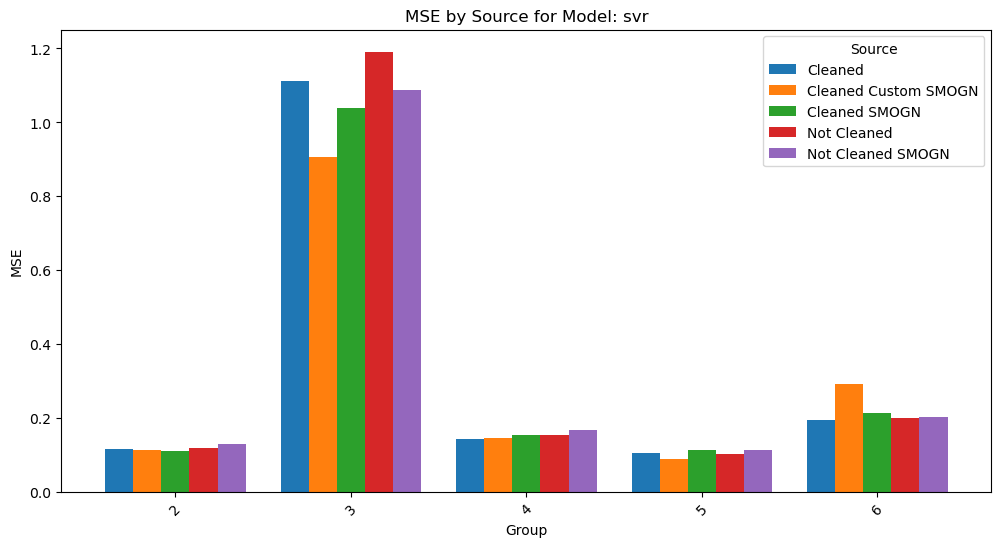

In [101]:
bar_plot_mse_by_source_per_model('svr', with_fp=False)

In [102]:
test_custom_smogn_mpe = compare_by_mpe(merged_test, regression_models_custom_smogn, predict_fn=np.exp)
test_custom_smogn_mpe['Source'] = 'Cleaned Custom SMOGN'
test_fp_mpe = calc_mpe_fp(fluor_test_df, with_group_5=False)
test_fp_mpe['Source'] = 'FP'
test_mpe_res = pd.concat([test_custom_smogn_mpe, test_fp_mpe])

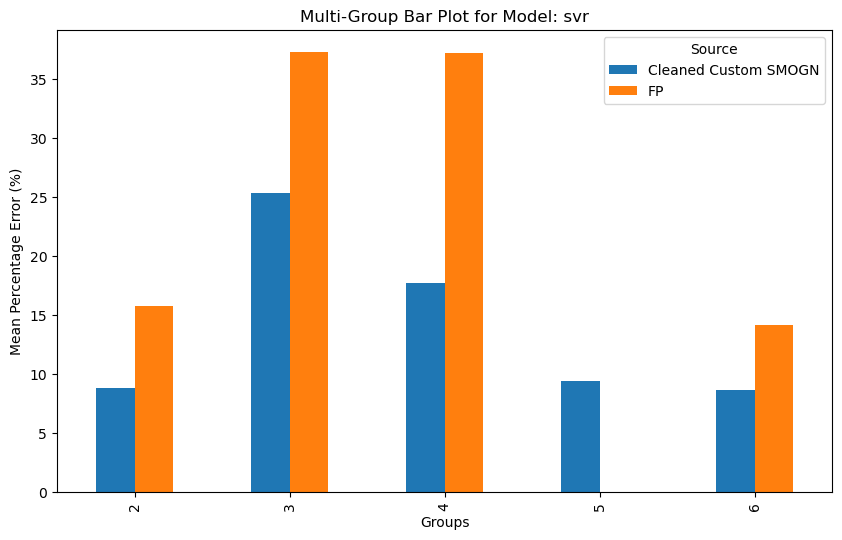

In [107]:
bar_plot_per_model_by_sources(test_mpe_res, 'svr')